<a id='imports'></a>

# Import Necessary Libraries

In [ ]:
import os
import datetime
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForQuestionAnswering,
    T5Tokenizer,
    T5ForConditionalGeneration,
    get_scheduler,
    AdamW
)
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import string
import re
from transformers import pipeline
import dotenv
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import optuna
import gc
import plotly.express as px
import json
from openai import OpenAI
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Load environment variables from a .env file.
dotenv.load_dotenv()


# Data Preparation Class


<a id='Data_Preparation_Class'></a>

In [3]:
class DataPreparation:
    def __init__(self, df=None):
        """
        Initializes the DataPreparation class.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
        """
        self.df = df
        self.contexts = None
        self.questions = None
        self.answers = None

    def extract_data(self):
        """Extracts contexts, questions, and answers from the dataframe."""
        self.contexts = self.df['context'].values.tolist()
        self.questions = self.df['question'].values.tolist()
        self.answers = self.df['answers'].values.tolist()

    def add_end_idx(self):
        """Adds the end index to each answer in the dataset."""
        updated_answers = []
        for answer, context in zip(self.answers, self.contexts):
            gold_text = answer['text'][0]
            start_idx = answer['answer_start'][0]
            end_idx = start_idx + len(gold_text)
            if context[start_idx:end_idx] == gold_text:
                answer['answer_end'] = [end_idx]
            else:
                for n in [1, 2]:
                    if context[start_idx - n:end_idx - n] == gold_text:
                        answer['answer_start'] = [start_idx - n]
                        answer['answer_end'] = [end_idx - n]
                        break
            updated_answers.append(answer)
        self.answers = updated_answers


<a id='imports'></a>

# Prepare the Training and Validation Data


<a id='Prepare_the_Training_and_Validation_Data'></a>


Initialisierung der Datenvorbereitung für Training und Validierung


In [4]:
train = DataPreparation() 
train.df = pd.read_parquet("hf://datasets/rajpurkar/squad/plain_text/train-00000-of-00001.parquet")

validation = DataPreparation()  
validation.df = pd.read_parquet("hf://datasets/rajpurkar/squad/plain_text/validation-00000-of-00001.parquet")


# Erstellung von Trainings- und Validierungsdaten für das Modell

<a id='erstellung'></a>


In [5]:
train_df = train.df
temp_df = validation.df

TD_B = temp_df.sample(n=100)  
TD_A = temp_df.drop(TD_B.index) 
# TD_B.to_excel("data/TD_B.xlsx", index=False) 


# Verarbeitung der Trainings-, Validierungs- und Testdaten

<a id='Verarbeitung'></a>

In [6]:
train_data = DataPreparation(df=train_df.reset_index(drop=True))
train_data.extract_data() 
train_data.add_end_idx()  

val_data = DataPreparation(df=TD_A.reset_index(drop=True))
val_data.extract_data()  
val_data.add_end_idx()  

test_data = DataPreparation(df=TD_B.reset_index(drop=True))
test_data.extract_data() 
test_data.add_end_idx()  


# Definition von SquadDataset und T5Dataset Klassen

<a id='Definition'></a>

ich erstelle 2 klassen, **`SquadDataset`** und **`T5Dataset`**, die für die Verarbeitung von Datensätzen verwendet werden.

1. **`SquadDataset`**:
   - Diese Klasse ist für die Verarbeitung von Daten im SQuAD-Format gedacht.
   - Sie kodiert die Eingaben (Kontexte und Fragen) mit einem Tokenizer und fügt Start- und Endpositionen der Antworten hinzu.
   - Dies ist nützlich für Aufgaben, bei denen die Position der Antwort im Kontext wichtig ist, wie z. B. bei Extraktionsaufgaben.

2. **`T5Dataset`**:
   - Diese Klasse wird für Text-zu-Text-Modelle wie T5 (Text-to-Text Transfer Transformer) verwendet.
   - Sie erstellt Eingabetexte (bestehend aus Fragen und Kontexten) und Zieltexte (Antworten).
   - Die Texte werden mit einem Tokenizer kodiert, wobei die maximale Sequenzlänge berücksichtigt wird.
   - Die Kodierungen werden dann als Eingaben und Labels für das Modell vorbereitet.

In [7]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, contexts, questions, answers, tokenizer):
        """
        Initialisiert die Klasse SquadDataset.

        Argumente:
            contexts (list): Liste von Kontext-Strings.
            questions (list): Liste von Fragen-Strings.
            answers (list): Liste von Antwort-Dictionaries (mit 'text', 'answer_start', 'answer_end').
            tokenizer (Tokenizer): Tokenizer für die Codierung.
        """
        self.contexts = contexts
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.encodings = self.tokenizer(contexts, questions, truncation=True, padding=True)
        self.add_token_positions(answers)

    def add_token_positions(self, answers):
        """Fügt Start- und Endpositionen zu den Codierungen hinzu."""
        start_positions = []
        end_positions = []
        for i in range(len(answers)):
            start_positions.append(
                self.encodings.char_to_token(i, answers[i]['answer_start'][0])
            )
            end_positions.append(
                self.encodings.char_to_token(i, answers[i]['answer_end'][0] - 1)
            )

            # Behandlung von Fällen, in denen die Antwort nicht im tokenisierten Input ist
            if start_positions[-1] is None:
                start_positions[-1] = self.encodings['input_ids'][i].index(self.tokenizer.sep_token_id)
            if end_positions[-1] is None:
                end_positions[-1] = self.encodings['input_ids'][i].index(self.tokenizer.sep_token_id)

        self.encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

    def __getitem__(self, idx):
        """Ruft das Element am angegebenen Index ab."""
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        """Gibt die Länge des Datensatzes zurück."""
        return len(self.encodings.input_ids)


class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, contexts, questions, answers, tokenizer, max_length=512):
        """
        Initialisiert die Klasse T5Dataset.

        Argumente:
            contexts (list): Liste von Kontext-Strings.
            questions (list): Liste von Fragen-Strings.
            answers (list): Liste von Antwort-Dictionaries (mit 'text').
            tokenizer (Tokenizer): T5 Tokenizer.
            max_length (int): Maximale Sequenzlänge.
        """
        self.contexts = contexts
        self.questions = questions
        self.answers = answers  # Jedes Antwort-Dictionary enthält eine Liste 'text', z.B. {'text': ["Antwort-String"]}
        self.targets_text = [ans['text'][0] for ans in answers]  # Referenztexte

        self.inputs = []
        self.targets = []
        for context, question, answer in zip(contexts, questions, answers):
            input_text = f"question: {question}  context: {context}"
            target_text = answer['text'][0]
            self.inputs.append(input_text)
            self.targets.append(target_text)

        self.tokenizer = tokenizer
        self.encodings = tokenizer(
            self.inputs,
            truncation=True,
            padding=True,
            max_length=max_length
        )
        self.target_encodings = tokenizer(
            self.targets,
            truncation=True,
            padding=True,
            max_length=max_length
        )

    def __getitem__(self, idx):
        """Ruft das Element am angegebenen Index ab."""
        input_ids = torch.tensor(self.encodings['input_ids'][idx])
        attention_mask = torch.tensor(self.encodings['attention_mask'][idx])
        labels = torch.tensor(self.target_encodings['input_ids'][idx])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

    def __len__(self):
        """Gibt die Länge des Datensatzes zurück."""
        return len(self.inputs)















 


Initialize Tokenizers and Create Datasets
We initialize the tokenizers and create the datasets for both models.

# Erstellung von Datensätzen für DistilBERT und T5




<a id='Erstellung_von_Datensaetzen'></a>



ich erstelle Datensätze für: **DistilBERT** und **T5** Modelle. Beide Modelle verwenden unterschiedliche Tokenizer und Datenformate. Die Schritte umfassen:

- Initialisierung der Tokenizer für DistilBERT und T5.
- Erstellung von Trainings-, Validierungs- und Testdatensätzen für jedes Modell.
- Verwendung von `SquadDataset` für DistilBERT (extraktive Aufgaben) und `T5Dataset` für T5 (generative Aufgaben).



In [8]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

distilbert_train_dataset = SquadDataset(
    contexts=train_data.contexts,
    questions=train_data.questions,
    answers=train_data.answers,
    tokenizer=distilbert_tokenizer
)

distilbert_val_dataset = SquadDataset(
    contexts=val_data.contexts,
    questions=val_data.questions,
    answers=val_data.answers,
    tokenizer=distilbert_tokenizer
)

distilbert_test_dataset = SquadDataset(
    contexts=test_data.contexts,
    questions=test_data.questions,
    answers=test_data.answers,
    tokenizer=distilbert_tokenizer
)

t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

t5_train_dataset = T5Dataset(
    contexts=train_data.contexts,
    questions=train_data.questions,
    answers=train_data.answers,
    tokenizer=t5_tokenizer
)

t5_val_dataset = T5Dataset(
    contexts=val_data.contexts,
    questions=val_data.questions,
    answers=val_data.answers,
    tokenizer=t5_tokenizer
)

t5_test_dataset = T5Dataset(
    contexts=test_data.contexts,
    questions=test_data.questions,
    answers=test_data.answers,
    tokenizer=t5_tokenizer
)






You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# Normalisierung von Antworten, Berechnung von EM und F1, und Modelltraining




<a id='normalisierung'></a>



Diese Zelle enthält die Definition von Funktionen und einer Klasse für die Normalisierung von Antworten, die Bewertung von Vorhersagen sowie das Training eines Modells. 

#### Hauptpunkte:
1. **Normalisierung von Antworten (`normalize_answer`)**:
   - Konvertiert Texte in Kleinbuchstaben, entfernt Artikel, Satzzeichen und zusätzliche Leerzeichen.
   
2. **Berechnung von Metriken (`compute_exact_match`, `compute_f1`)**:
   - `compute_exact_match`: Berechnet, ob die Vorhersage genau der Referenz entspricht.
   - `compute_f1`: Berechnet den F1-Score basierend auf der Übereinstimmung von Token zwischen Vorhersage und Referenz.

3. **`ModelTrainer`-Klasse**:
   - Unterstützt das Training und die Validierung von Modellen (z. B. DistilBERT und T5).
   - Enthält:
     - Optimierung und Training des Modells mit Early Stopping.
     - Speicherung von Modellen nach jedem Epoch.
     - Berechnung der EM- und F1-Werte für Validierungs- und Testdatensätze.
     - Unterstützung für verschiedene Modelltypen (`distilbert` und `t5`).

In [9]:



def normalize_answer(s):
    """Konvertiert Text in Kleinbuchstaben und entfernt Satzzeichen, Artikel und zusätzliche Leerzeichen."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def compute_exact_match(prediction, ground_truth):
    """Berechnet, ob die Vorhersage genau der Referenz entspricht (Exact Match)."""

    return int(normalize_answer(prediction) == normalize_answer(ground_truth))


def compute_f1(prediction, ground_truth):
    """Berechnet den F1-Score basierend auf der Übereinstimmung von Tokens zwischen Vorhersage und Referenz."""
    pred_tokens = normalize_answer(prediction).split()
    gt_tokens = normalize_answer(ground_truth).split()
    common = set(pred_tokens) & set(gt_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gt_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


class ModelTrainer:
    def __init__(self, model, tokenizer, train_dataset, val_dataset, model_type='distilbert', device=None):
        """
        Initialisiert die ModelTrainer-Klasse.

        Argumente:
            model (nn.Module): Das Modell, das trainiert werden soll.
            tokenizer (Tokenizer): Der verwendete Tokenizer.
            train_dataset (Dataset): Trainingsdatensatz.
            val_dataset (Dataset): Validierungsdatensatz.
            model_type (str): Typ des Modells ('distilbert' oder 't5').
            device (str): Zu verwendendes Gerät ('cuda' oder 'cpu').
        """
        self.model = model
        self.tokenizer = tokenizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.model_type = model_type
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.optimizer = None
        self.loss_history = {'Epoch':[], 'Training Loss': [], 'Validation Loss':[], 'f1_score':[], 'exact_match':[]}

    def initialize_optimizer(self, lr=5e-5):
        """Initialisiert den Optimierer."""
        self.optimizer = AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)

    def train(self, epochs=1, batch_size=16, early_stopping_patience=5, save_dir='/data', model_name='model', lr=5e-5):
        """
        Trainiert das Modell mit Early Stopping und speichert das Modell nach jedem Epoch.

        Argumente:
            epochs (int): Anzahl der Epochen für das Training.
            batch_size (int): Batch-Größe für das Training.
            early_stopping_patience (int): Anzahl der Epochen für Early Stopping.
            save_dir (str): Verzeichnis zum Speichern der Modelle.
            model_name (str): Basisname für die gespeicherten Modelle.
        """
        # Create save directory if it doesn't exist
        model_save_dir = os.path.join(save_dir, model_name)
        os.makedirs(model_save_dir, exist_ok=True)

        # Initialize variables for early stopping
        best_val_loss = float('inf')
        patience = 0

        # Initialize optimizer if not already done
        if self.optimizer is None:
            if lr:
                self.initialize_optimizer(lr)
            else:
                self.initialize_optimizer()

        # Data loaders
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size)

        for epoch in range(epochs):
            epoch += 1 
            # Training phase
            self.model.train()
            train_loss = 0
            loop = tqdm(train_loader, leave=True)
            for batch in loop:
                self.optimizer.zero_grad()

                # Move batch to device
                batch = {k: v.to(self.device) for k, v in batch.items()}

                # Handle different models
                if self.model_type == 'distilbert':
                    outputs = self.model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        start_positions=batch['start_positions'],
                        end_positions=batch['end_positions']
                    )
                elif self.model_type == 't5':
                    # Replace padding token id's of the labels by -100
                    labels = batch['labels'].clone()
                    labels[labels == self.tokenizer.pad_token_id] = -100
                    outputs = self.model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=labels
                    )
                else:
                    raise ValueError("Unsupported model type")

                loss = outputs.loss
                loss.backward()
                self.optimizer.step()
                #scheduler.step()
                train_loss += loss.item()

                loop.set_description(f'Epoch {epoch}')
                loop.set_postfix(loss=loss.item())

            avg_train_loss = train_loss / len(train_loader)

            # Validation phase
            val_loss = self.evaluate_loss(val_loader)
            print(f"Epoch {epoch} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
            self.loss_history['Epoch'].append(epoch)
            self.loss_history['Training Loss'].append(avg_train_loss)
            self.loss_history['Validation Loss'].append(val_loss)
            try:
                em, f1 = self.evaluate_model(self.val_dataset, batch_size=batch_size )
            except:
                em, f1 = 0, 0
            self.loss_history['f1_score'].append(f1)
            self.loss_history['exact_match'].append(em)

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
            else:
                patience += 1
                if patience >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

            # Save the model
            date_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            model_filename = f"{model_name}_epoch{epoch}_{date_time}.pt"
            model_path = os.path.join(model_save_dir, model_filename)
            self.save_model(model_path)

        # After training, set model to eval mode
        self.model.eval()

    def evaluate_loss(self, data_loader):
        """Evaluates the model on the validation dataset and returns the average loss."""
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in data_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}

                if self.model_type == 'distilbert':
                    outputs = self.model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        start_positions=batch['start_positions'],
                        end_positions=batch['end_positions']
                    )
                elif self.model_type == 't5':
                    labels = batch['labels'].clone()
                    labels[labels == self.tokenizer.pad_token_id] = -100
                    outputs = self.model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=labels
                    )
                else:
                    raise ValueError("Unsupported model type")

                loss = outputs.loss
                total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)
        return avg_loss

    def evaluate_model(self, test_dataset, batch_size=16):
        """
        Evaluates the model on a test dataset using EM and F1.

        Args:
            test_dataset (Dataset): Test dataset.
            batch_size (int): Batch size for evaluation.
        """
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        if self.model_type == 'distilbert':
            em, f1 = self.evaluate_distilbert_em_f1(test_dataset, test_loader)
        elif self.model_type == 't5':
            em, f1 = self.evaluate_t5_em_f1(test_dataset, test_loader)
        else:
            raise ValueError("Unsupported model type")

        print(f"EM: {em:.2f}, F1: {f1:.2f}")
        return em, f1

    def evaluate_distilbert_em_f1(self, dataset, data_loader):
        """Evaluates the DistilBERT model using EM and F1 metrics."""
        self.model.eval()
        predictions = []
        references = []

        # dataset.contexts, dataset.answers
        # We'll extract predicted answers and compare to ground truth.

        for batch_idx, batch in enumerate(tqdm(data_loader, desc="Evaluating DistilBERT")):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_mask)
                start_logits = outputs.start_logits
                end_logits = outputs.end_logits

            # For each example in the batch
            for i in range(input_ids.size(0)):
                start_idx = torch.argmax(start_logits[i]).item()
                end_idx = torch.argmax(end_logits[i]).item()
                # Handle the case if end_idx < start_idx
                if end_idx < start_idx:
                    # Swap or just pick start_idx for both (no valid answer)
                    end_idx = start_idx

                # Convert IDs back to text
                input_ids_example = input_ids[i].tolist()
                answer_ids = input_ids_example[start_idx:end_idx+1]
                pred_answer = self.tokenizer.decode(answer_ids, skip_special_tokens=True)

                # Retrieve the reference answer from dataset
                # Since we don't know the exact indexing in batches, we should rely on the global index
                # One approach: keep a global counter or rely on data loader providing indices
                # Let's assume data_loader is not doing any fancy stuff and we can reconstruct indices.
                # Alternatively, store original indexes in dataset and use a sampler.
                # For simplicity, assume batch_idx * batch_size + i is the dataset index.
                dataset_idx = batch_idx * data_loader.batch_size + i
                ref_answers = dataset.answers[dataset_idx]['text']
                # For SQuAD typically there's one reference answer or multiple. We take the first.
                ref_answer = ref_answers[0]

                predictions.append(pred_answer)
                references.append(ref_answer)

        # Compute EM and F1
        total_em = 0
        total_f1 = 0
        for pred, ref in zip(predictions, references):
            total_em += compute_exact_match(pred, ref)
            total_f1 += compute_f1(pred, ref)

        em = 100.0 * total_em / len(predictions)
        f1 = 100.0 * total_f1 / len(predictions)

        return em, f1

    def evaluate_t5_em_f1(self, dataset, data_loader):
        """Evaluates the T5 model using EM and F1 metrics."""
        self.model.eval()
        predictions = []
        references = dataset.targets  # direct references from the dataset

        for batch_idx, batch in enumerate(tqdm(data_loader, desc="Evaluating T5")):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=50
                )

            preds = [self.tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
            predictions.extend(preds)

        # Compute EM and F1
        total_em = 0
        total_f1 = 0
        for pred, ref in zip(predictions, references):
            total_em += compute_exact_match(pred, ref)
            total_f1 += compute_f1(pred, ref)

        em = 100.0 * total_em / len(predictions)
        f1 = 100.0 * total_f1 / len(predictions)

        return em, f1

    def get_model(self):
        """Returns the trained model."""
        return self.model

    def save_model(self, save_path):
        """Saves the model to the specified path."""
        torch.save(self.model.state_dict(), save_path)
    def get_loss_table(self):
        """Returns the loss history as a DataFrame."""

        return pd.DataFrame(self.loss_history, columns=['Epoch', 'Training Loss', 'Validation Loss', 'f1_score', 'exact_match'])


# Hyperparameter-Tuning für DistilBERT mit Optuna


<a id='hyperparameter'></a>



hier wird das Hyperparameter-Tuning für das DistilBERT-Modell mithilfe der **Optuna-Bibliothek** durchgeführt. Der Fokus liegt darauf, die optimalen Werte für **Lernrate (`lr`)** und **Batch-Größe (`batch_size`)** zu finden, um die Modellleistung zu maximieren.

#### Hauptpunkte:
1. **Ziel-Funktion (`objective`)**:
   - Führt ein Training des DistilBERT-Modells mit verschiedenen Hyperparametern durch, die von Optuna vorgeschlagen werden.
   - Bewertet das Modell basierend auf dem **F1-Score**.
   - Speichert die Verlaufsdaten der Verluste (Loss-Tabelle) für jeden Versuch global.

2. **Optuna-Optimierung**:
   - Erstellt eine **Study**, die darauf abzielt, den **F1-Score** zu maximieren.
   - Führt mehrere Versuche durch (`n_trials=20`), um die besten Hyperparameter zu finden.

3. **Ressourcenverwaltung**:
   - Nach jedem Versuch werden Speicherressourcen freigegeben, um Speicherlecks zu vermeiden.



In [25]:


DISTILBERT_LOSS_TABLES = []

def objective(trial):
    global DISTILBERT_LOSS_TABLES  

    lr = trial.suggest_float("lr", 1e-6, 1e-4, log=True)  
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])  

    model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
    trainer = ModelTrainer(
        model=model,
        tokenizer=distilbert_tokenizer,
        train_dataset=distilbert_train_dataset,
        val_dataset=distilbert_val_dataset,
        model_type='distilbert',
    )
    
    trainer.train(
        epochs=20,
        batch_size=batch_size,
        early_stopping_patience=2,
        save_dir='./data_draft', 
        model_name='temp',
        lr=lr
    )

    # Bewertung des Modells, um den F1-Score zu berechnen.
    em, f1 = trainer.evaluate_model(distilbert_val_dataset)

    # Speichern der Loss-Tabelle dieses Versuchs in der globalen Liste.
    loss_table = trainer.get_loss_table()
    DISTILBERT_LOSS_TABLES.append(loss_table)
    
    del model
    del trainer
    import gc
    gc.collect()
    torch.cuda.empty_cache()

    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)



print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)


[I 2025-01-08 04:55:22,040] A new study created in memory with name: no-name-be418ff8-7a8d-4755-a607-2756cf1d992b
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [16:10<00:00,  2.82it/s, loss=1.43] 


Epoch 1 - Training Loss: 1.4862, Validation Loss: 1.1909


Evaluating DistilBERT: 100%|██████████| 328/328 [00:40<00:00,  8.11it/s]


EM: 53.87, F1: 68.79


Epoch 2: 100%|██████████| 2738/2738 [15:46<00:00,  2.89it/s, loss=1.43] 


Epoch 2 - Training Loss: 0.9373, Validation Loss: 1.1481


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.37it/s]


EM: 54.55, F1: 69.80


Epoch 3: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=0.185]


Epoch 3 - Training Loss: 0.6949, Validation Loss: 1.2595


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.36it/s]


EM: 53.99, F1: 69.43


Epoch 4: 100%|██████████| 2738/2738 [15:43<00:00,  2.90it/s, loss=0.155]


Epoch 4 - Training Loss: 0.5271, Validation Loss: 1.3569


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.33it/s]


EM: 53.60, F1: 68.91
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:40<00:00, 16.32it/s]


EM: 53.60, F1: 68.91


[I 2025-01-08 06:04:30,244] Trial 0 finished with value: 68.91286293788673 and parameters: {'lr': 7.473471506045419e-05, 'batch_size': 32}. Best is trial 0 with value: 68.91286293788673.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [16:40<00:00,  5.47it/s, loss=1.65] 


Epoch 1 - Training Loss: 2.4829, Validation Loss: 1.6212


Evaluating DistilBERT: 100%|██████████| 655/655 [00:40<00:00, 16.31it/s]


EM: 42.68, F1: 57.46


Epoch 2: 100%|██████████| 5475/5475 [16:47<00:00,  5.43it/s, loss=1.41] 


Epoch 2 - Training Loss: 1.5463, Validation Loss: 1.3745


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.49it/s]


EM: 47.85, F1: 62.87


Epoch 3: 100%|██████████| 5475/5475 [16:39<00:00,  5.48it/s, loss=1.01] 


Epoch 3 - Training Loss: 1.3284, Validation Loss: 1.2771


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.50it/s]


EM: 50.71, F1: 65.78


Epoch 4: 100%|██████████| 5475/5475 [16:39<00:00,  5.48it/s, loss=1.16] 


Epoch 4 - Training Loss: 1.1947, Validation Loss: 1.2306


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.49it/s]


EM: 52.36, F1: 67.03


Epoch 5: 100%|██████████| 5475/5475 [16:38<00:00,  5.48it/s, loss=1.05] 


Epoch 5 - Training Loss: 1.0939, Validation Loss: 1.2048


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.51it/s]


EM: 53.24, F1: 68.05


Epoch 6: 100%|██████████| 5475/5475 [16:38<00:00,  5.48it/s, loss=1.37] 


Epoch 6 - Training Loss: 1.0130, Validation Loss: 1.1752


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.51it/s]


EM: 54.01, F1: 68.79


Epoch 7: 100%|██████████| 5475/5475 [16:37<00:00,  5.49it/s, loss=0.928]


Epoch 7 - Training Loss: 0.9467, Validation Loss: 1.1896


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.50it/s]


EM: 54.20, F1: 69.13


Epoch 8: 100%|██████████| 5475/5475 [16:38<00:00,  5.49it/s, loss=0.788]


Epoch 8 - Training Loss: 0.8856, Validation Loss: 1.1804


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.51it/s]


EM: 54.43, F1: 69.62
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.53it/s]


EM: 54.43, F1: 69.62


[I 2025-01-08 08:28:50,509] Trial 1 finished with value: 69.6158615020638 and parameters: {'lr': 2.6869400321901386e-06, 'batch_size': 16}. Best is trial 1 with value: 69.6158615020638.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=1.99] 


Epoch 1 - Training Loss: 1.5383, Validation Loss: 1.1514


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.40it/s]


EM: 54.75, F1: 69.55


Epoch 2: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.993]


Epoch 2 - Training Loss: 0.9485, Validation Loss: 1.1315


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.38it/s]


EM: 55.62, F1: 70.74


Epoch 3: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.42] 


Epoch 3 - Training Loss: 0.6967, Validation Loss: 1.2164


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.38it/s]


EM: 55.86, F1: 70.86


Epoch 4: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.392]


Epoch 4 - Training Loss: 0.5157, Validation Loss: 1.3012


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.39it/s]


EM: 54.58, F1: 70.03
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.50it/s]


EM: 54.58, F1: 70.03


[I 2025-01-08 09:37:06,564] Trial 2 finished with value: 70.03216299305807 and parameters: {'lr': 3.69466526352872e-05, 'batch_size': 32}. Best is trial 2 with value: 70.03216299305807.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.85]


Epoch 1 - Training Loss: 2.8388, Validation Loss: 1.7571


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 39.43, F1: 54.14


Epoch 2: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.6] 


Epoch 2 - Training Loss: 1.6730, Validation Loss: 1.4736


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 44.98, F1: 60.56


Epoch 3: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.58] 


Epoch 3 - Training Loss: 1.4489, Validation Loss: 1.3644


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 48.45, F1: 63.50


Epoch 4: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.11] 


Epoch 4 - Training Loss: 1.3175, Validation Loss: 1.2943


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 50.30, F1: 65.40


Epoch 5: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.09] 


Epoch 5 - Training Loss: 1.2196, Validation Loss: 1.2601


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 51.40, F1: 66.38


Epoch 6: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.05] 


Epoch 6 - Training Loss: 1.1412, Validation Loss: 1.2238


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.26, F1: 67.19


Epoch 7: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.33] 


Epoch 7 - Training Loss: 1.0752, Validation Loss: 1.2083


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 53.42, F1: 68.32


Epoch 8: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=0.78] 


Epoch 8 - Training Loss: 1.0171, Validation Loss: 1.2040


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 53.73, F1: 68.56


Epoch 9: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=0.983]


Epoch 9 - Training Loss: 0.9634, Validation Loss: 1.1917


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 54.15, F1: 69.14


Epoch 10: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.21] 


Epoch 10 - Training Loss: 0.9146, Validation Loss: 1.2048


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 54.40, F1: 69.28


Epoch 11: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.2]  


Epoch 11 - Training Loss: 0.8717, Validation Loss: 1.2002


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 54.57, F1: 69.48
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.47it/s]


EM: 54.57, F1: 69.48


[I 2025-01-08 12:38:09,423] Trial 3 finished with value: 69.48309399448935 and parameters: {'lr': 3.766909165517106e-06, 'batch_size': 64}. Best is trial 2 with value: 70.03216299305807.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=1.27] 


Epoch 1 - Training Loss: 2.3887, Validation Loss: 1.5446


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.37it/s]


EM: 43.76, F1: 58.69


Epoch 2: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=1.88] 


Epoch 2 - Training Loss: 1.4767, Validation Loss: 1.3457


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.36it/s]


EM: 48.93, F1: 64.05


Epoch 3: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=0.917]


Epoch 3 - Training Loss: 1.2769, Validation Loss: 1.2620


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.39it/s]


EM: 51.17, F1: 66.23


Epoch 4: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=1.6]  


Epoch 4 - Training Loss: 1.1530, Validation Loss: 1.2205


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.39it/s]


EM: 52.93, F1: 67.85


Epoch 5: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.702]


Epoch 5 - Training Loss: 1.0547, Validation Loss: 1.1896


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.38it/s]


EM: 53.90, F1: 68.67


Epoch 6: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.673]


Epoch 6 - Training Loss: 0.9785, Validation Loss: 1.1928


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.39it/s]


EM: 54.09, F1: 68.85


Epoch 7: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.618]


Epoch 7 - Training Loss: 0.9041, Validation Loss: 1.1847


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.38it/s]


EM: 54.70, F1: 69.48


Epoch 8: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.562]


Epoch 8 - Training Loss: 0.8411, Validation Loss: 1.2050


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.41it/s]


EM: 54.75, F1: 69.51


Epoch 9: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=1.42] 


Epoch 9 - Training Loss: 0.7861, Validation Loss: 1.2064


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.38it/s]


EM: 54.95, F1: 69.78
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.49it/s]


EM: 54.95, F1: 69.78


[I 2025-01-08 15:10:55,759] Trial 4 finished with value: 69.77842371812345 and parameters: {'lr': 4.128252373568465e-06, 'batch_size': 32}. Best is trial 2 with value: 70.03216299305807.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=2.29]


Epoch 1 - Training Loss: 2.8667, Validation Loss: 1.7886


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.36it/s]


EM: 39.33, F1: 53.36


Epoch 2: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=1.15] 


Epoch 2 - Training Loss: 1.6753, Validation Loss: 1.4490


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.38it/s]


EM: 46.47, F1: 61.49


Epoch 3: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=2.21] 


Epoch 3 - Training Loss: 1.4259, Validation Loss: 1.3352


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.37it/s]


EM: 49.19, F1: 64.10


Epoch 4: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=1.39] 


Epoch 4 - Training Loss: 1.2842, Validation Loss: 1.2690


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.40it/s]


EM: 51.46, F1: 66.16


Epoch 5: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.618]


Epoch 5 - Training Loss: 1.1864, Validation Loss: 1.2296


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.38it/s]


EM: 52.51, F1: 67.36


Epoch 6: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=1.44] 


Epoch 6 - Training Loss: 1.1054, Validation Loss: 1.2047


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.37it/s]


EM: 53.06, F1: 67.78


Epoch 7: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=0.919]


Epoch 7 - Training Loss: 1.0367, Validation Loss: 1.2008


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.37it/s]


EM: 53.70, F1: 68.51


Epoch 8: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=0.443]


Epoch 8 - Training Loss: 0.9814, Validation Loss: 1.1763


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.39it/s]


EM: 54.13, F1: 68.91


Epoch 9: 100%|██████████| 2738/2738 [15:37<00:00,  2.92it/s, loss=1.31] 


Epoch 9 - Training Loss: 0.9272, Validation Loss: 1.1781


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.39it/s]


EM: 54.93, F1: 69.58


Epoch 10: 100%|██████████| 2738/2738 [15:38<00:00,  2.92it/s, loss=0.865]


Epoch 10 - Training Loss: 0.8781, Validation Loss: 1.1924


Evaluating DistilBERT: 100%|██████████| 328/328 [00:39<00:00,  8.40it/s]


EM: 54.84, F1: 69.56
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.48it/s]


EM: 54.84, F1: 69.56


[I 2025-01-08 18:00:38,048] Trial 5 finished with value: 69.56046526845506 and parameters: {'lr': 2.906830814864574e-06, 'batch_size': 32}. Best is trial 2 with value: 70.03216299305807.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [16:42<00:00,  5.46it/s, loss=2.11] 


Epoch 1 - Training Loss: 2.7211, Validation Loss: 1.7258


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 39.71, F1: 54.27


Epoch 2: 100%|██████████| 5475/5475 [16:39<00:00,  5.48it/s, loss=1.26] 


Epoch 2 - Training Loss: 1.6658, Validation Loss: 1.4784


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 45.48, F1: 60.39


Epoch 3: 100%|██████████| 5475/5475 [16:39<00:00,  5.48it/s, loss=1.43] 


Epoch 3 - Training Loss: 1.4432, Validation Loss: 1.3563


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.49it/s]


EM: 49.18, F1: 64.11


Epoch 4: 100%|██████████| 5475/5475 [16:40<00:00,  5.47it/s, loss=1.53] 


Epoch 4 - Training Loss: 1.3105, Validation Loss: 1.2919


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.49it/s]


EM: 50.86, F1: 65.77


Epoch 5: 100%|██████████| 5475/5475 [16:40<00:00,  5.47it/s, loss=0.779]


Epoch 5 - Training Loss: 1.2156, Validation Loss: 1.2426


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.47it/s]


EM: 51.83, F1: 66.85


Epoch 6: 100%|██████████| 5475/5475 [16:40<00:00,  5.47it/s, loss=0.97] 


Epoch 6 - Training Loss: 1.1331, Validation Loss: 1.2183


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.50it/s]


EM: 52.73, F1: 67.64


Epoch 7: 100%|██████████| 5475/5475 [16:39<00:00,  5.48it/s, loss=0.912]


Epoch 7 - Training Loss: 1.0674, Validation Loss: 1.2044


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.50it/s]


EM: 53.30, F1: 68.14


Epoch 8: 100%|██████████| 5475/5475 [16:49<00:00,  5.43it/s, loss=0.867]


Epoch 8 - Training Loss: 1.0104, Validation Loss: 1.1953


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.41it/s]


EM: 53.94, F1: 68.94


Epoch 9: 100%|██████████| 5475/5475 [16:43<00:00,  5.46it/s, loss=0.546]


Epoch 9 - Training Loss: 0.9598, Validation Loss: 1.1990


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.44it/s]


EM: 53.98, F1: 69.02


Epoch 10: 100%|██████████| 5475/5475 [16:41<00:00,  5.47it/s, loss=0.68] 


Epoch 10 - Training Loss: 0.9124, Validation Loss: 1.1999


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 54.17, F1: 69.19
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 54.17, F1: 69.19


[I 2025-01-08 21:01:33,205] Trial 6 finished with value: 69.19395599850105 and parameters: {'lr': 1.8947321010398338e-06, 'batch_size': 16}. Best is trial 2 with value: 70.03216299305807.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.956]


Epoch 1 - Training Loss: 1.5805, Validation Loss: 1.1386


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.70, F1: 69.35


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.05] 


Epoch 2 - Training Loss: 0.9429, Validation Loss: 1.1128


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.21it/s]


EM: 56.35, F1: 71.19


Epoch 3: 100%|██████████| 1369/1369 [15:11<00:00,  1.50it/s, loss=0.633]


Epoch 3 - Training Loss: 0.6908, Validation Loss: 1.2044


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 55.54, F1: 70.59


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.732]


Epoch 4 - Training Loss: 0.5190, Validation Loss: 1.3660


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.79, F1: 69.94
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.42it/s]


EM: 54.79, F1: 69.94


[I 2025-01-08 22:08:00,138] Trial 7 finished with value: 69.94056326151149 and parameters: {'lr': 5.681769037608866e-05, 'batch_size': 64}. Best is trial 2 with value: 70.03216299305807.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.82]


Epoch 1 - Training Loss: 2.4318, Validation Loss: 1.4982


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 45.57, F1: 60.64


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.96] 


Epoch 2 - Training Loss: 1.4127, Validation Loss: 1.2865


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 50.50, F1: 65.51


Epoch 3: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.26] 


Epoch 3 - Training Loss: 1.1990, Validation Loss: 1.2090


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.75, F1: 67.72


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.971]


Epoch 4 - Training Loss: 1.0661, Validation Loss: 1.1748


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.04, F1: 69.08


Epoch 5: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.15] 


Epoch 5 - Training Loss: 0.9608, Validation Loss: 1.1788


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.66, F1: 69.58


Epoch 6: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=0.808]


Epoch 6 - Training Loss: 0.8751, Validation Loss: 1.1700


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.16, F1: 70.06


Epoch 7: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.523]


Epoch 7 - Training Loss: 0.7996, Validation Loss: 1.1980


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.58, F1: 70.39


Epoch 8: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=0.549]


Epoch 8 - Training Loss: 0.7326, Validation Loss: 1.2071


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.46, F1: 70.44
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.42it/s]


EM: 55.46, F1: 70.44


[I 2025-01-09 00:20:06,247] Trial 8 finished with value: 70.43775561333086 and parameters: {'lr': 7.629137626401345e-06, 'batch_size': 64}. Best is trial 8 with value: 70.43775561333086.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [16:41<00:00,  5.47it/s, loss=1.39] 


Epoch 1 - Training Loss: 1.5500, Validation Loss: 1.2571


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 52.50, F1: 67.17


Epoch 2: 100%|██████████| 5475/5475 [16:40<00:00,  5.47it/s, loss=0.456]


Epoch 2 - Training Loss: 1.0366, Validation Loss: 1.3342


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.45it/s]


EM: 51.77, F1: 66.59


Epoch 3: 100%|██████████| 5475/5475 [16:40<00:00,  5.47it/s, loss=0.313]


Epoch 3 - Training Loss: 0.7983, Validation Loss: 1.3028


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.45it/s]


EM: 52.19, F1: 67.02
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.45it/s]


EM: 52.19, F1: 67.02


[I 2025-01-09 01:14:42,493] Trial 9 finished with value: 67.01606282414137 and parameters: {'lr': 8.650894478887454e-05, 'batch_size': 16}. Best is trial 8 with value: 70.43775561333086.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.38] 


Epoch 1 - Training Loss: 1.9498, Validation Loss: 1.2832


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 50.46, F1: 65.49


Epoch 2: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=1.42] 


Epoch 2 - Training Loss: 1.1893, Validation Loss: 1.1763


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 53.79, F1: 68.75


Epoch 3: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=1.34] 


Epoch 3 - Training Loss: 0.9882, Validation Loss: 1.1400


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 54.63, F1: 69.68


Epoch 4: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=0.809]


Epoch 4 - Training Loss: 0.8404, Validation Loss: 1.1683


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 55.41, F1: 70.43


Epoch 5: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=0.841]


Epoch 5 - Training Loss: 0.7174, Validation Loss: 1.1972


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.67, F1: 70.64
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.44it/s]


EM: 55.67, F1: 70.64


[I 2025-01-09 02:37:28,716] Trial 10 finished with value: 70.64001633126685 and parameters: {'lr': 1.4896328636439193e-05, 'batch_size': 64}. Best is trial 10 with value: 70.64001633126685.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=1.47] 


Epoch 1 - Training Loss: 2.0833, Validation Loss: 1.3440


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 49.47, F1: 64.16


Epoch 2: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=1.11] 


Epoch 2 - Training Loss: 1.2483, Validation Loss: 1.2088


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.60, F1: 67.42


Epoch 3: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=1.24] 


Epoch 3 - Training Loss: 1.0449, Validation Loss: 1.1546


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 54.60, F1: 69.53


Epoch 4: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.35] 


Epoch 4 - Training Loss: 0.8954, Validation Loss: 1.1644


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 54.78, F1: 69.63


Epoch 5: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=0.65] 


Epoch 5 - Training Loss: 0.7778, Validation Loss: 1.1690


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 55.39, F1: 70.34
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 55.38, F1: 70.34


[I 2025-01-09 04:00:12,872] Trial 11 finished with value: 70.33826143912711 and parameters: {'lr': 1.3042372589974593e-05, 'batch_size': 64}. Best is trial 10 with value: 70.64001633126685.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=1.29] 


Epoch 1 - Training Loss: 2.0414, Validation Loss: 1.3475


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 48.68, F1: 63.71


Epoch 2: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=1.14] 


Epoch 2 - Training Loss: 1.2627, Validation Loss: 1.2074


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.02, F1: 67.13


Epoch 3: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=0.96] 


Epoch 3 - Training Loss: 1.0633, Validation Loss: 1.1688


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.24, F1: 69.31


Epoch 4: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=0.642]


Epoch 4 - Training Loss: 0.9232, Validation Loss: 1.1533


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.95, F1: 70.10


Epoch 5: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=0.976]


Epoch 5 - Training Loss: 0.8105, Validation Loss: 1.1701


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.11, F1: 70.25


Epoch 6: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=0.819]


Epoch 6 - Training Loss: 0.7112, Validation Loss: 1.2090


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.02, F1: 70.02
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.42it/s]


EM: 55.02, F1: 70.02


[I 2025-01-09 05:39:22,766] Trial 12 finished with value: 70.02046058178989 and parameters: {'lr': 1.1432096605462077e-05, 'batch_size': 64}. Best is trial 10 with value: 70.64001633126685.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.13] 


Epoch 1 - Training Loss: 1.8658, Validation Loss: 1.2364


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 51.79, F1: 66.77


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.927]


Epoch 2 - Training Loss: 1.1111, Validation Loss: 1.1318


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.15, F1: 69.98


Epoch 3: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.965]


Epoch 3 - Training Loss: 0.8927, Validation Loss: 1.1390


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.58, F1: 70.52


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.519]


Epoch 4 - Training Loss: 0.7354, Validation Loss: 1.1761


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.58, F1: 70.52
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.42it/s]


EM: 55.58, F1: 70.52


[I 2025-01-09 06:45:46,955] Trial 13 finished with value: 70.52378746927351 and parameters: {'lr': 2.1326242486149807e-05, 'batch_size': 64}. Best is trial 10 with value: 70.64001633126685.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.5]  


Epoch 1 - Training Loss: 1.7269, Validation Loss: 1.2069


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.76, F1: 67.86


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.674]


Epoch 2 - Training Loss: 1.0464, Validation Loss: 1.1194


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.24it/s]


EM: 55.39, F1: 70.43


Epoch 3: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=1.03] 


Epoch 3 - Training Loss: 0.8201, Validation Loss: 1.1819


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.36, F1: 70.41


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.541]


Epoch 4 - Training Loss: 0.6528, Validation Loss: 1.2519


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.64, F1: 70.47
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.42it/s]


EM: 55.64, F1: 70.47


[I 2025-01-09 07:52:10,538] Trial 14 finished with value: 70.47037836858766 and parameters: {'lr': 2.7757690211086414e-05, 'batch_size': 64}. Best is trial 10 with value: 70.64001633126685.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.32] 


Epoch 1 - Training Loss: 1.8161, Validation Loss: 1.2433


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.19, F1: 66.96


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.887]


Epoch 2 - Training Loss: 1.1138, Validation Loss: 1.1562


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.81, F1: 69.49


Epoch 3: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.3]  


Epoch 3 - Training Loss: 0.8990, Validation Loss: 1.1392


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.81, F1: 70.74


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.62] 


Epoch 4 - Training Loss: 0.7386, Validation Loss: 1.1879


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.85, F1: 70.76


Epoch 5: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.698]


Epoch 5 - Training Loss: 0.6055, Validation Loss: 1.2826


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 55.28, F1: 70.14
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.41it/s]


EM: 55.28, F1: 70.14


[I 2025-01-09 09:15:00,535] Trial 15 finished with value: 70.13983819253394 and parameters: {'lr': 2.0986711644777516e-05, 'batch_size': 64}. Best is trial 10 with value: 70.64001633126685.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:11<00:00,  1.50it/s, loss=1.46]


Epoch 1 - Training Loss: 2.4993, Validation Loss: 1.5735


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 43.26, F1: 57.88


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.9]  


Epoch 2 - Training Loss: 1.4575, Validation Loss: 1.3271


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 49.76, F1: 64.53


Epoch 3: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.02] 


Epoch 3 - Training Loss: 1.2353, Validation Loss: 1.2281


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.15, F1: 67.00


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.11] 


Epoch 4 - Training Loss: 1.0993, Validation Loss: 1.1814


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 53.40, F1: 68.29


Epoch 5: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.04] 


Epoch 5 - Training Loss: 0.9949, Validation Loss: 1.1717


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.03, F1: 69.15


Epoch 6: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.17] 


Epoch 6 - Training Loss: 0.9098, Validation Loss: 1.1586


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.57, F1: 69.58


Epoch 7: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=0.586]


Epoch 7 - Training Loss: 0.8325, Validation Loss: 1.1703


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.78, F1: 69.92


Epoch 8: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.781]


Epoch 8 - Training Loss: 0.7647, Validation Loss: 1.2092


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.79, F1: 69.89
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.41it/s]


EM: 54.79, F1: 69.89


[I 2025-01-09 11:27:10,019] Trial 16 finished with value: 69.88810799058487 and parameters: {'lr': 7.063563573992978e-06, 'batch_size': 64}. Best is trial 10 with value: 70.64001633126685.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.45] 


Epoch 1 - Training Loss: 1.9199, Validation Loss: 1.2755


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 50.65, F1: 65.97


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.18] 


Epoch 2 - Training Loss: 1.1618, Validation Loss: 1.1645


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 54.41, F1: 69.44


Epoch 3: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.04] 


Epoch 3 - Training Loss: 0.9521, Validation Loss: 1.1374


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.80, F1: 70.59


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.832]


Epoch 4 - Training Loss: 0.7984, Validation Loss: 1.1797


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.64, F1: 70.69


Epoch 5: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.905]


Epoch 5 - Training Loss: 0.6737, Validation Loss: 1.2077


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 55.75, F1: 70.96
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.40it/s]


EM: 55.75, F1: 70.96


[I 2025-01-09 12:50:01,722] Trial 17 finished with value: 70.95744017968443 and parameters: {'lr': 1.708166830805197e-05, 'batch_size': 64}. Best is trial 17 with value: 70.95744017968443.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1369/1369 [15:11<00:00,  1.50it/s, loss=3.19]


Epoch 1 - Training Loss: 4.0784, Validation Loss: 3.1624


Evaluating DistilBERT: 100%|██████████| 164/164 [00:39<00:00,  4.20it/s]


EM: 10.79, F1: 19.09


Epoch 2: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=2.56]


Epoch 2 - Training Loss: 2.6641, Validation Loss: 2.0716


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.21it/s]


EM: 32.44, F1: 45.81


Epoch 3: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.53]


Epoch 3 - Training Loss: 2.0240, Validation Loss: 1.7733


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 38.56, F1: 52.98


Epoch 4: 100%|██████████| 1369/1369 [15:11<00:00,  1.50it/s, loss=1.81]


Epoch 4 - Training Loss: 1.8000, Validation Loss: 1.6407


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 41.21, F1: 56.17


Epoch 5: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.91]


Epoch 5 - Training Loss: 1.6732, Validation Loss: 1.5575


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 43.40, F1: 58.57


Epoch 6: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.31] 


Epoch 6 - Training Loss: 1.5823, Validation Loss: 1.4988


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 44.79, F1: 60.00


Epoch 7: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.71] 


Epoch 7 - Training Loss: 1.5084, Validation Loss: 1.4455


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 46.22, F1: 61.44


Epoch 8: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.5]  


Epoch 8 - Training Loss: 1.4463, Validation Loss: 1.4132


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 47.09, F1: 62.38


Epoch 9: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.11] 


Epoch 9 - Training Loss: 1.3961, Validation Loss: 1.3805


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 47.85, F1: 63.01


Epoch 10: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.47] 


Epoch 10 - Training Loss: 1.3485, Validation Loss: 1.3587


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 48.76, F1: 63.89


Epoch 11: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.25] 


Epoch 11 - Training Loss: 1.3115, Validation Loss: 1.3387


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 49.41, F1: 64.47


Epoch 12: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.25] 


Epoch 12 - Training Loss: 1.2741, Validation Loss: 1.3192


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 49.80, F1: 64.93


Epoch 13: 100%|██████████| 1369/1369 [15:11<00:00,  1.50it/s, loss=1.33] 


Epoch 13 - Training Loss: 1.2419, Validation Loss: 1.2979


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 50.31, F1: 65.50


Epoch 14: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.957]


Epoch 14 - Training Loss: 1.2093, Validation Loss: 1.2907


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 50.74, F1: 65.72


Epoch 15: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.819]


Epoch 15 - Training Loss: 1.1812, Validation Loss: 1.2711


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 51.33, F1: 66.25


Epoch 16: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.19] 


Epoch 16 - Training Loss: 1.1529, Validation Loss: 1.2607


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 51.53, F1: 66.44


Epoch 17: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.13] 


Epoch 17 - Training Loss: 1.1278, Validation Loss: 1.2551


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 51.93, F1: 66.99


Epoch 18: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=0.78] 


Epoch 18 - Training Loss: 1.1041, Validation Loss: 1.2444


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.21, F1: 67.12


Epoch 19: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.12] 


Epoch 19 - Training Loss: 1.0812, Validation Loss: 1.2362


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.13, F1: 67.18


Epoch 20: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.11] 


Epoch 20 - Training Loss: 1.0595, Validation Loss: 1.2347


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 52.49, F1: 67.55


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.40it/s]


EM: 52.49, F1: 67.55


[I 2025-01-09 18:19:30,256] Trial 18 finished with value: 67.54707768368144 and parameters: {'lr': 1.2784112998482085e-06, 'batch_size': 64}. Best is trial 17 with value: 70.95744017968443.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [16:42<00:00,  5.46it/s, loss=0.89] 


Epoch 1 - Training Loss: 1.6376, Validation Loss: 1.1928


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.44it/s]


EM: 53.50, F1: 68.16


Epoch 2: 100%|██████████| 5475/5475 [16:42<00:00,  5.46it/s, loss=1.11] 


Epoch 2 - Training Loss: 1.0377, Validation Loss: 1.1120


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 55.75, F1: 70.39


Epoch 3: 100%|██████████| 5475/5475 [16:42<00:00,  5.46it/s, loss=1.39] 


Epoch 3 - Training Loss: 0.8041, Validation Loss: 1.1498


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.46it/s]


EM: 55.65, F1: 70.60


Epoch 4: 100%|██████████| 5475/5475 [16:42<00:00,  5.46it/s, loss=0.757] 


Epoch 4 - Training Loss: 0.6323, Validation Loss: 1.1920


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.43it/s]


EM: 55.88, F1: 70.82
Early stopping triggered


Evaluating DistilBERT: 100%|██████████| 655/655 [00:39<00:00, 16.43it/s]


EM: 55.88, F1: 70.82


[I 2025-01-09 19:32:12,423] Trial 19 finished with value: 70.82149040944778 and parameters: {'lr': 1.5072356678903132e-05, 'batch_size': 16}. Best is trial 17 with value: 70.95744017968443.


Best parameters: {'lr': 1.708166830805197e-05, 'batch_size': 64}
Best F1 score: 70.95744017968443


die Ergebnisse des Hyperparameter-Tunings mit Optuna aus, einschließlich der besten Hyperparameter, des höchsten erreichten **F1-Scores** und einer Zusammenfassung aller durchgeführten Versuche.

#### Hauptpunkte:
1. **Beste Hyperparameter und F1-Score**:
   - Zeigt die von Optuna gefundenen optimalen Hyperparameter und den zugehörigen F1-Score.

2. **Zusammenfassung der Versuche**:
   - Listet alle Versuche auf, einschließlich der folgenden Informationen:
     - **Versuchsnummer**: Die Nummer des Versuchs.
     - **Erreichter Wert**: Der F1-Score für den Versuch.
     - **Verwendete Hyperparameter**: Die in diesem Versuch getesteten Werte.

#### Nutzen:
- Hilft dabei, die Hyperparameter-Optimierung zu analysieren und nachzuvollziehen.
- Gibt Einblick in die getesteten Kombinationen und deren Ergebnisse.



In [66]:
# Ausgabe der besten Hyperparameter und des zugehörigen F1-Scores aus der Optuna-Studie.
print("Beste Parameter:", study.best_params)  # Optimale Hyperparameter
print("Bester F1-Score:", study.best_value)  # Höchster erreichter F1-Score

# Ausgabe einer Zusammenfassung aller Versuche, um Ergebnisse und getestete Parameter zu überprüfen.
print("\n=== Zusammenfassung der Versuche ===")
for trial in study.trials:
    # Ausgabe der Versuchsdaten: Nummer, erzielter Wert (F1-Score) und getestete Hyperparameter.
    print(f"Versuch #{trial.number}, Wert: {trial.value}, Parameter: {trial.params}")


Beste Parameter: {'lr': 1.708166830805197e-05, 'batch_size': 64}
Bester F1-Score: 70.95744017968443

=== Zusammenfassung der Versuche ===
Versuch #0, Wert: 68.91286293788673, Parameter: {'lr': 7.473471506045419e-05, 'batch_size': 32}
Versuch #1, Wert: 69.6158615020638, Parameter: {'lr': 2.6869400321901386e-06, 'batch_size': 16}
Versuch #2, Wert: 70.03216299305807, Parameter: {'lr': 3.69466526352872e-05, 'batch_size': 32}
Versuch #3, Wert: 69.48309399448935, Parameter: {'lr': 3.766909165517106e-06, 'batch_size': 64}
Versuch #4, Wert: 69.77842371812345, Parameter: {'lr': 4.128252373568465e-06, 'batch_size': 32}
Versuch #5, Wert: 69.56046526845506, Parameter: {'lr': 2.906830814864574e-06, 'batch_size': 32}
Versuch #6, Wert: 69.19395599850105, Parameter: {'lr': 1.8947321010398338e-06, 'batch_size': 16}
Versuch #7, Wert: 69.94056326151149, Parameter: {'lr': 5.681769037608866e-05, 'batch_size': 64}
Versuch #8, Wert: 70.43775561333086, Parameter: {'lr': 7.629137626401345e-06, 'batch_size': 64

### Analyse der Optuna-Trials für **DistilBERT**

### 1. **Beste Ergebnisse**
- **Beste Hyperparameter**:
  - Lernrate: 1.71 x 10^-5
  - Batchgröße: 64
- **Höchster F1-Score**: **70.96** (Versuch #17)
- Diese Ergebnisse zeigen, dass eine moderate Lernrate und eine größere Batchgröße optimal für dieses Setup sind.

---

### 2. **Zusammenfassung der Versuche**
- Durchschnittlicher F1-Score: **69.55**
- Streuung der Ergebnisse:
  - **Höchster F1-Score:** 70.96 (Versuch #17)
  - **Niedrigster F1-Score:** 67.02 (Versuch #9)
- **Lernrate (`lr`)**:
  - Lernraten im Bereich 1.4 x 10^-5 bis 2.8 x 10^-5 erzielten durchweg F1-Werte über 70.
  - Zu niedrige Lernraten (z. B. 1.28 x 10^-6 in Versuch #18) oder zu hohe Lernraten (z. B. 8.65 x 10^-5 in Versuch #9) führten zu schlechteren Ergebnissen.
- **Batchgröße (`batch_size`)**:
  - Batchgröße 64 erzielte die besten Ergebnisse. Von den 20 Versuchen erzielten 13 mit Batchgröße 64 F1-Scores über 70.
  - Batchgrößen 16 und 32 waren weniger konsistent.





hier werden die Verlustkurven für Trainings- und Validierungsdaten über mehrere Optuna-Versuche hinweg visualisiert. Die Hauptmerkmale der Zelle sind:

1. **Subplot-Layout**:
   - Erzeugt ein Gitter von Subplots, wobei jede Grafik einem Versuch entspricht.
   - Die Anzahl der Zeilen und Spalten wird basierend auf der Gesamtanzahl der Versuche dynamisch berechnet.

2. **Inhalt der Plots**:
   - Jeder Plot zeigt:
     - **Training Loss**: Der Verlust auf den Trainingsdaten pro Epoch.
     - **Validation Loss**: Der Verlust auf den Validierungsdaten pro Epoch.
   - Jeder Plot enthält Metainformationen:
     - **Versuchsnummer**.
     - **Erreichter F1-Score**.
     - **Verwendete Hyperparameter**.

3. **Optimierungen**:
   - Entfernt nicht verwendete Subplots, falls die Anzahl der Versuche geringer ist als die Anzahl der verfügbaren Subplots.
   - Optimiert die Anordnung der Plots für bessere Lesbarkeit.

#### Ziel:
Die Visualisierung hilft dabei, die Leistung des Modells in jedem Versuch zu analysieren und das Verhalten der Verlustkurven über die Epochen hinweg zu vergleichen.


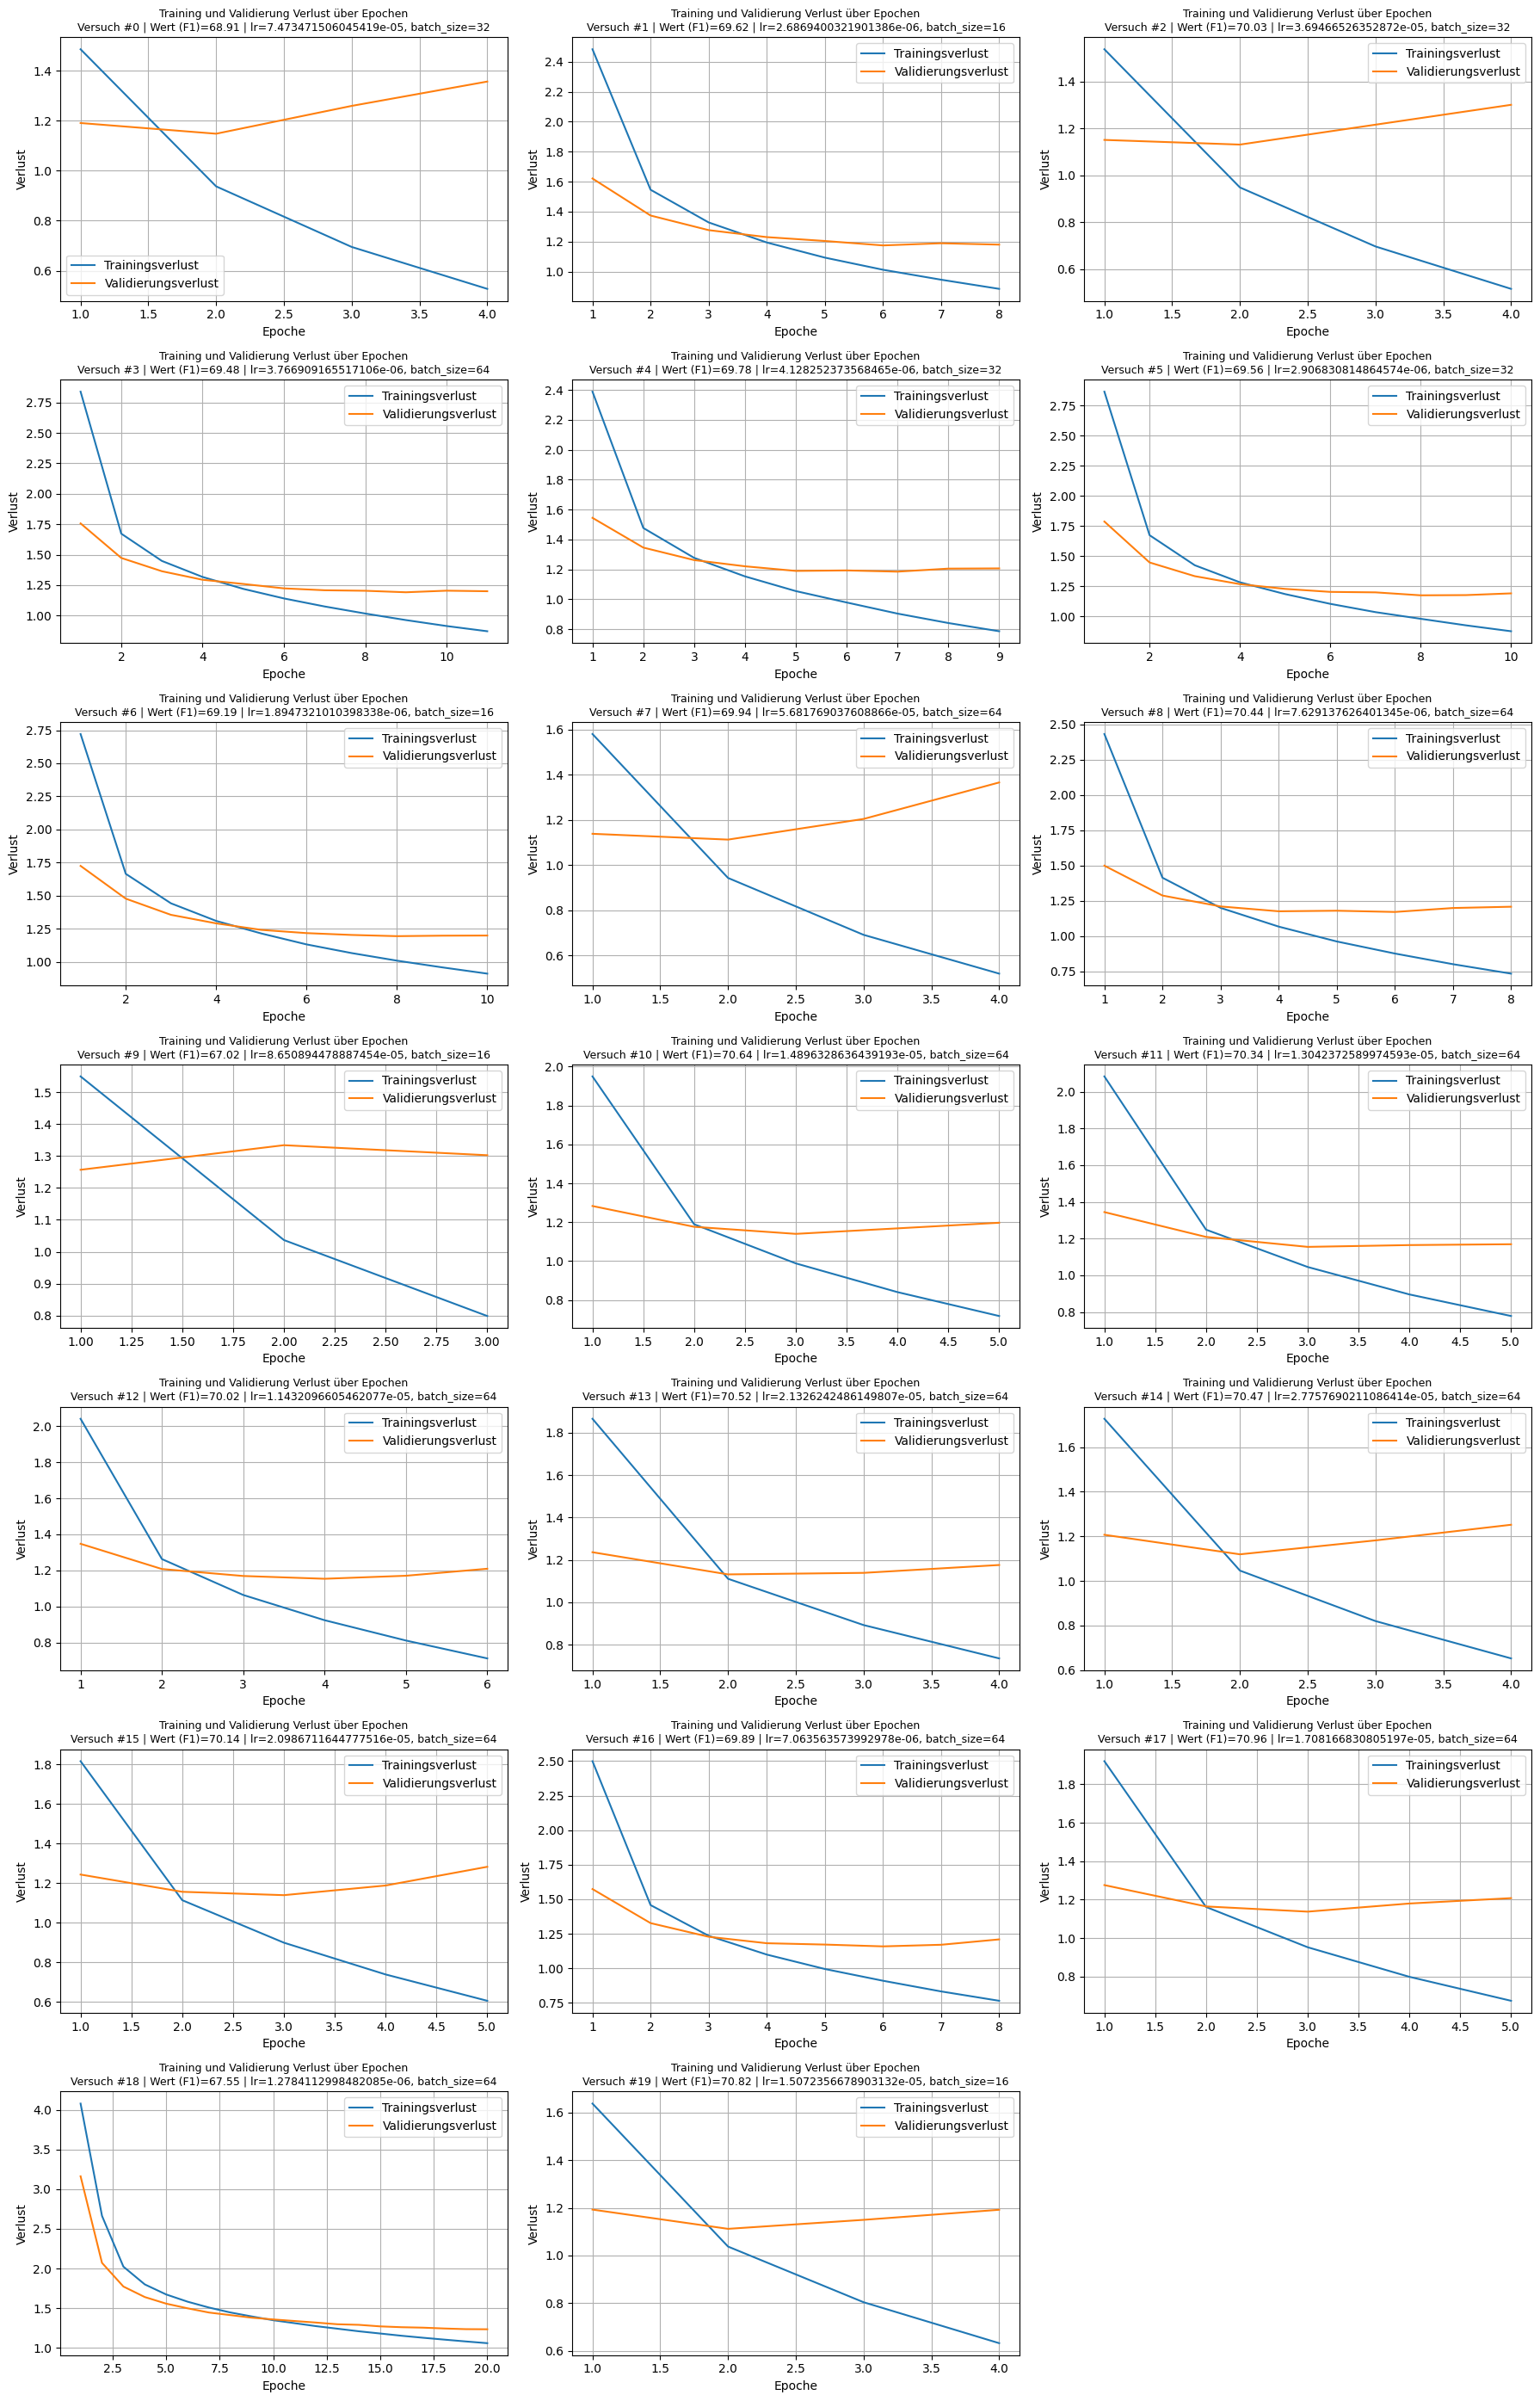

In [67]:
num_trials = len(DISTILBERT_LOSS_TABLES)  # Anzahl der durchgeführten Versuche

# Bestimmung des Layouts für das Subplot-Gitter.
num_cols = 3  # Anzahl der Spalten
num_rows = math.ceil(num_trials / num_cols)  # Anzahl der Zeilen basierend auf der Anzahl der Versuche

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6 * num_cols, 4 * num_rows))

# Glättung des Arrays von Achsen für eine einfache Indizierung, falls es mehrere Versuche gibt.
axs_flat = axs.flatten() if num_trials > 1 else [axs]

for i, (df, trial) in enumerate(zip(DISTILBERT_LOSS_TABLES, study.trials)):
    ax = axs_flat[i]

    # Extrahierung der Versuchsinformationen.
    trial_number = trial.number
    trial_value = trial.value
    trial_params = trial.params

    # Formatierung der Parameter für die Anzeige.
    params_str = ", ".join([f"{k}={v}" for k, v in trial_params.items()])

    # Titel und Untertitel der Grafik.
    main_title = "Training und Validierung Verlust über Epochen"
    subtitle = f"Versuch #{trial_number} | Wert (F1)={trial_value:.2f} | {params_str}"
    full_title = main_title + "\n" + subtitle

    # Plotten der Trainings- und Validierungsverlustkurven.
    ax.plot(df["Epoch"], df["Training Loss"], label="Trainingsverlust")
    ax.plot(df["Epoch"], df["Validation Loss"], label="Validierungsverlust")

    ax.set_xlabel("Epoche")  # X-Achse
    ax.set_ylabel("Verlust")  # Y-Achse
    ax.set_title(full_title, fontsize=9)  # Titel
    ax.grid(True)  # Hinzufügen eines Gitters
    ax.legend()  # Hinzufügen einer Legende

# Entfernen ungenutzter Subplots, falls die Anzahl der Versuche geringer ist als die Anzahl der Subplots.
if num_trials < len(axs_flat):
    for j in range(num_trials, len(axs_flat)):
        fig.delaxes(axs_flat[j])

plt.tight_layout()  # Optimierte Anordnung der Subplots
plt.show()  # Anzeigen der Plots



In dieser Zelle wird das DistilBERT-Modell für die Aufgabe der Fragebeantwortung mithilfe der optimalen Hyperparameter aus der Optuna-Studie trainiert. 


In [ ]:
# Laden des DistilBERT-Modells für die Fragebeantwortung.
distilbert_model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')

# Initialisierung des ModelTrainer mit dem DistilBERT-Modell, Tokenizer und den Datensätzen.
distilbert_trainer = ModelTrainer(
    model=distilbert_model,
    tokenizer=distilbert_tokenizer,
    train_dataset=distilbert_train_dataset,
    val_dataset=distilbert_val_dataset,
    model_type='distilbert'
)

# Training des Modells mit den besten Hyperparametern aus der Optuna-Studie.
distilbert_trainer.train(
    epochs=10,  # Anzahl der Epochen
    batch_size=study.trials[18].params['batch_size'],  # Optimale Batch-Größe
    early_stopping_patience=2,  # Early Stopping nach 2 Epochen ohne Verbesserung
    save_dir='./data',  # Speicherort für das Modell
    model_name='distilbert_qa',  # Name des Modells
    lr=study.trials[18].params['lr']  # Optimale Lernrate
)

# Speichern des trainierten Modells in einer Datei.
distilbert_trainer.save_model('distilbert_qa.pt')


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 1369/1369 [15:24<00:00,  1.48it/s, loss=3.19]


Epoch 1 - Training Loss: 3.9284, Validation Loss: 2.8244


Evaluating DistilBERT: 100%|██████████| 164/164 [00:40<00:00,  4.06it/s]


EM: 16.27, F1: 26.72


Epoch 2: 100%|██████████| 1369/1369 [15:21<00:00,  1.49it/s, loss=2.36]


Epoch 2 - Training Loss: 2.6161, Validation Loss: 2.2189


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.21it/s]


EM: 28.90, F1: 41.69


Epoch 3: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=1.89]


Epoch 3 - Training Loss: 2.1162, Validation Loss: 1.8074


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 38.55, F1: 52.85


Epoch 4: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=1.73]


Epoch 4 - Training Loss: 1.8215, Validation Loss: 1.6579


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 41.14, F1: 56.05


Epoch 5: 100%|██████████| 1369/1369 [15:10<00:00,  1.50it/s, loss=2.03]


Epoch 5 - Training Loss: 1.6760, Validation Loss: 1.5574


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 43.45, F1: 58.64


Epoch 6: 100%|██████████| 1369/1369 [15:09<00:00,  1.50it/s, loss=1.47] 


Epoch 6 - Training Loss: 1.5793, Validation Loss: 1.4989


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 44.72, F1: 59.94


Epoch 7: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=1.58]


Epoch 7 - Training Loss: 1.5014, Validation Loss: 1.4449


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 46.25, F1: 61.23


Epoch 8: 100%|██████████| 1369/1369 [15:09<00:00,  1.51it/s, loss=1.3]  


Epoch 8 - Training Loss: 1.4392, Validation Loss: 1.4059


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 47.19, F1: 62.17


Epoch 9: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.58] 


Epoch 9 - Training Loss: 1.3852, Validation Loss: 1.3736


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.22it/s]


EM: 48.12, F1: 63.12


Epoch 10: 100%|██████████| 1369/1369 [15:08<00:00,  1.51it/s, loss=1.23] 


Epoch 10 - Training Loss: 1.3394, Validation Loss: 1.3469


Evaluating DistilBERT: 100%|██████████| 164/164 [00:38<00:00,  4.23it/s]


EM: 48.81, F1: 63.95


In [127]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Daten aus deiner Tabelle
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_loss = distilbert_trainer.get_loss_table()['Training Loss']
val_loss = distilbert_trainer.get_loss_table()['Validation Loss']
f1_score = distilbert_trainer.get_loss_table()['f1_score']
exact_match = distilbert_trainer.get_loss_table()['exact_match']

# Erstelle Subplots: 1 Reihe, 2 Spalten
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    subplot_titles=('Training und Validierung Verlust', 'F1-Score und Exact Match'),
    shared_xaxes=True,
    vertical_spacing=0.1,
    specs=[[{"secondary_y": True}, {"secondary_y": True}]]  # Aktiviert sekundäre y-Achsen für beide Subplots
)

# Füge den Trainingsverlust hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Trainingsverlust', line=dict(color='blue')),
    row=1, col=1
)

# Füge den Validierungsverlust hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validierungsverlust', line=dict(color='red')),
    row=1, col=1
)

# Füge den F1-Score hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=f1_score, mode='lines+markers', name='F1-Score', line=dict(color='green')),
    row=1, col=2
)

# Füge den Exact Match (exakte Übereinstimmung) hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=exact_match, mode='lines+markers', name='Exact Match', line=dict(color='orange')),
    row=1, col=2
)

# Layout anpassen mit Titeln und Achsenbezeichnern
fig.update_layout(
    title_text='Training/Validierungsverlust und Evaluationsmetriken',
    xaxis_title='Epoch',
    showlegend=True,
    height=500
)

# Y-Achse für den ersten Subplot (Verlust) anpassen
fig.update_yaxes(title_text='Verlust', row=1, col=1)

# Y-Achse für den zweiten Subplot (F1-Score und Exact Match) anpassen
fig.update_yaxes(title_text='Punktzahl', row=1, col=2)

# Das Diagramm anzeigen
fig.show()


# Hyperparameter-Tuning für T5-Modell mit Optuna

<a id='hyperparameter'></a>


Ich führe eine Hyperparameter-Optimierung für das **T5-Modell** durch, um die besten Werte für **Lernrate (`lr`)**, **Batch-Größe (`batch_size`)** und **Epochen (`epochs`)** zu finden. Die Optimierung erfolgt mit der Optuna-Bibliothek und hat folgende Schritte:

#### Hauptpunkte:
1. **Ziel-Funktion (`objective_t5`)**:
   - Trainiert das T5-Modell mit den vorgeschlagenen Hyperparametern.
   - Bewertet die Modellleistung anhand von **F1**- und **Exact Match (EM)**-Metriken auf dem Validierungsdatensatz.
   - Speichert die Verlustkurven (Loss-Tabelle) jedes Versuchs für die spätere Analyse.

2. **Optuna-Optimierung**:
   - Führt eine Hyperparameter-Suche durch, um den **F1-Score** zu maximieren.
   - Testet 20 verschiedene Hyperparameter-Kombinationen (`n_trials=20`).

3. **Ergebnisse**:
   - Gibt die besten Hyperparameter und den höchsten F1-Score aus.
   - Bereitet das Modell für die spätere Verwendung oder Feinabstimmung vor.

#### Ziel:
Das optimierte T5-Modell soll maximale Leistung für generative Frage-Antwort-Aufgaben erzielen.



In [29]:
T5_LOSS_TABLES = []

def objective_t5(trial):
    global T5_LOSS_TABLES 
    
    lr = trial.suggest_float("lr", 1e-6, 1e-4, log=True)  
    batch_size = trial.suggest_categorical("batch_size", [16, 32]) 
    epochs = trial.suggest_categorical("epochs", [10]) 
    # Initialisierung des T5-Modells.
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    
    # Initialisierung des ModelTrainer für T5, Konfiguration des Tokenizers, der Datensätze und des Modelltyps.
    trainer = ModelTrainer(
        model=model,
        tokenizer=t5_tokenizer,
        train_dataset=t5_train_dataset,
        val_dataset=t5_val_dataset,
        model_type='t5' 
    )
    
    # Training des Modells mit den vorgeschlagenen Hyperparametern.
    trainer.train(
        epochs=epochs,
        batch_size=batch_size,
        early_stopping_patience=2, 
        save_dir='./data_t5_optuna', 
        model_name='temp_t5', 
        lr=lr 
    )
    
    em, f1 = trainer.evaluate_model(t5_val_dataset)
    
    loss_table = trainer.get_loss_table()
    T5_LOSS_TABLES.append(loss_table)
    
    del model
    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    
    # Rückgabe des F1-Scores als Zielwert.
    return f1

study_t5 = optuna.create_study(direction="maximize")
study_t5.optimize(objective_t5, n_trials=20)  

print("=== T5 Hyperparameter Search ===")
print("Best parameters:", study_t5.best_params)
print("Best F1 score:", study_t5.best_value)


[I 2025-01-10 00:07:11,927] A new study created in memory with name: no-name-8b0dc595-4fd0-486e-9c33-7f352710bc42
Epoch 1: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.426] 


Epoch 1 - Training Loss: 0.4107, Validation Loss: 0.4244


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.65it/s]


EM: 63.49, F1: 77.37


Epoch 2: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.604] 


Epoch 2 - Training Loss: 0.3896, Validation Loss: 0.4172


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.61it/s]


EM: 64.00, F1: 77.77


Epoch 3: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.156] 


Epoch 3 - Training Loss: 0.3766, Validation Loss: 0.4154


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.62it/s]


EM: 64.00, F1: 77.78


Epoch 4: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.329] 


Epoch 4 - Training Loss: 0.3658, Validation Loss: 0.4146


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.59it/s]


EM: 63.91, F1: 77.83


Epoch 5: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.5]   


Epoch 5 - Training Loss: 0.3581, Validation Loss: 0.4102


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.62it/s]


EM: 64.04, F1: 77.88


Epoch 6: 100%|██████████| 5475/5475 [15:04<00:00,  6.06it/s, loss=0.302] 


Epoch 6 - Training Loss: 0.3512, Validation Loss: 0.4101


Evaluating T5: 100%|██████████| 655/655 [02:25<00:00,  4.50it/s]


EM: 64.09, F1: 77.93


Epoch 7: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.31]  


Epoch 7 - Training Loss: 0.3433, Validation Loss: 0.4062


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.59it/s]


EM: 64.38, F1: 78.09


Epoch 8: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.507] 


Epoch 8 - Training Loss: 0.3382, Validation Loss: 0.4092


Evaluating T5: 100%|██████████| 655/655 [02:19<00:00,  4.68it/s]


EM: 64.30, F1: 78.07


Epoch 9: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.305] 


Epoch 9 - Training Loss: 0.3326, Validation Loss: 0.4085


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.61it/s]


EM: 64.51, F1: 78.21
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.61it/s]


EM: 64.51, F1: 78.21


[I 2025-01-10 02:51:35,799] Trial 0 finished with value: 78.21042562235282 and parameters: {'lr': 7.2407553740205155e-06, 'batch_size': 16, 'epochs': 10}. Best is trial 0 with value: 78.21042562235282.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [15:02<00:00,  6.07it/s, loss=0.424] 


Epoch 1 - Training Loss: 0.4133, Validation Loss: 0.4295


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.57it/s]


EM: 63.48, F1: 77.33


Epoch 2: 100%|██████████| 5475/5475 [15:02<00:00,  6.07it/s, loss=0.211] 


Epoch 2 - Training Loss: 0.3942, Validation Loss: 0.4243


Evaluating T5: 100%|██████████| 655/655 [02:19<00:00,  4.70it/s]


EM: 63.72, F1: 77.52


Epoch 3: 100%|██████████| 5475/5475 [15:01<00:00,  6.07it/s, loss=0.261] 


Epoch 3 - Training Loss: 0.3853, Validation Loss: 0.4180


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.63it/s]


EM: 63.87, F1: 77.64


Epoch 4: 100%|██████████| 5475/5475 [15:01<00:00,  6.07it/s, loss=0.544] 


Epoch 4 - Training Loss: 0.3788, Validation Loss: 0.4154


Evaluating T5: 100%|██████████| 655/655 [02:18<00:00,  4.73it/s]


EM: 63.93, F1: 77.73


Epoch 5: 100%|██████████| 5475/5475 [15:01<00:00,  6.07it/s, loss=0.481] 


Epoch 5 - Training Loss: 0.3692, Validation Loss: 0.4160


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.60it/s]


EM: 63.75, F1: 77.75


Epoch 6: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.236] 


Epoch 6 - Training Loss: 0.3637, Validation Loss: 0.4104


Evaluating T5: 100%|██████████| 655/655 [02:19<00:00,  4.69it/s]


EM: 64.01, F1: 77.71


Epoch 7: 100%|██████████| 5475/5475 [15:09<00:00,  6.02it/s, loss=0.225] 


Epoch 7 - Training Loss: 0.3579, Validation Loss: 0.4142


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.65it/s]


EM: 64.21, F1: 77.92


Epoch 8: 100%|██████████| 5475/5475 [15:02<00:00,  6.07it/s, loss=0.342] 


Epoch 8 - Training Loss: 0.3545, Validation Loss: 0.4079


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.67it/s]


EM: 64.18, F1: 77.87


Epoch 9: 100%|██████████| 5475/5475 [15:02<00:00,  6.06it/s, loss=0.393] 


Epoch 9 - Training Loss: 0.3464, Validation Loss: 0.4084


Evaluating T5: 100%|██████████| 655/655 [02:18<00:00,  4.72it/s]


EM: 64.27, F1: 77.92


Epoch 10: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.407] 


Epoch 10 - Training Loss: 0.3441, Validation Loss: 0.4090


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.65it/s]


EM: 64.25, F1: 77.95
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.67it/s]


EM: 64.25, F1: 77.95


[I 2025-01-10 05:53:30,944] Trial 1 finished with value: 77.9463979955641 and parameters: {'lr': 4.991323019590899e-06, 'batch_size': 16, 'epochs': 10}. Best is trial 0 with value: 78.21042562235282.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.486]


Epoch 1 - Training Loss: 0.3971, Validation Loss: 0.4131


Evaluating T5: 100%|██████████| 328/328 [01:31<00:00,  3.57it/s]


EM: 64.02, F1: 77.52


Epoch 2: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.22] 


Epoch 2 - Training Loss: 0.3510, Validation Loss: 0.3973


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.14it/s]


EM: 64.21, F1: 77.74


Epoch 3: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.225]


Epoch 3 - Training Loss: 0.3215, Validation Loss: 0.4034


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 64.51, F1: 78.08


Epoch 4: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.316]


Epoch 4 - Training Loss: 0.2993, Validation Loss: 0.4141


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.33it/s]


EM: 64.63, F1: 78.08
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.66it/s]


EM: 64.63, F1: 78.08


[I 2025-01-10 06:58:39,294] Trial 2 finished with value: 78.08164992371549 and parameters: {'lr': 7.843895393619643e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 78.21042562235282.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.303]


Epoch 1 - Training Loss: 0.4218, Validation Loss: 0.4329


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.13it/s]


EM: 63.10, F1: 77.16


Epoch 2: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.364]


Epoch 2 - Training Loss: 0.4098, Validation Loss: 0.4296


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.19it/s]


EM: 63.22, F1: 77.17


Epoch 3: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.488]


Epoch 3 - Training Loss: 0.4034, Validation Loss: 0.4271


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.19it/s]


EM: 63.30, F1: 77.29


Epoch 4: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.43] 


Epoch 4 - Training Loss: 0.3966, Validation Loss: 0.4255


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.25it/s]


EM: 63.43, F1: 77.33


Epoch 5: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.36] 


Epoch 5 - Training Loss: 0.3935, Validation Loss: 0.4229


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 63.53, F1: 77.41


Epoch 6: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.454]


Epoch 6 - Training Loss: 0.3907, Validation Loss: 0.4222


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.21it/s]


EM: 63.47, F1: 77.38


Epoch 7: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.126]


Epoch 7 - Training Loss: 0.3873, Validation Loss: 0.4204


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 63.51, F1: 77.44


Epoch 8: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.326]


Epoch 8 - Training Loss: 0.3828, Validation Loss: 0.4194


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.21it/s]


EM: 63.70, F1: 77.52


Epoch 9: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.393]


Epoch 9 - Training Loss: 0.3806, Validation Loss: 0.4192


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.25it/s]


EM: 63.63, F1: 77.50


Epoch 10: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.482]


Epoch 10 - Training Loss: 0.3783, Validation Loss: 0.4188


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 63.64, F1: 77.53


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.58it/s]


EM: 63.64, F1: 77.53


[I 2025-01-10 09:38:26,010] Trial 3 finished with value: 77.53431256461528 and parameters: {'lr': 1.8863159203546548e-06, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 78.21042562235282.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.363]


Epoch 1 - Training Loss: 0.4163, Validation Loss: 0.4302


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.22it/s]


EM: 63.42, F1: 77.35


Epoch 2: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.286]


Epoch 2 - Training Loss: 0.4038, Validation Loss: 0.4274


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.19it/s]


EM: 63.43, F1: 77.38


Epoch 3: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.355]


Epoch 3 - Training Loss: 0.3954, Validation Loss: 0.4228


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.22it/s]


EM: 63.63, F1: 77.52


Epoch 4: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.458]


Epoch 4 - Training Loss: 0.3905, Validation Loss: 0.4207


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 63.61, F1: 77.49


Epoch 5: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.205]


Epoch 5 - Training Loss: 0.3853, Validation Loss: 0.4197


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 63.69, F1: 77.53


Epoch 6: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.511]


Epoch 6 - Training Loss: 0.3792, Validation Loss: 0.4183


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 63.57, F1: 77.51


Epoch 7: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.417]


Epoch 7 - Training Loss: 0.3766, Validation Loss: 0.4172


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.19it/s]


EM: 63.58, F1: 77.45


Epoch 8: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.404]


Epoch 8 - Training Loss: 0.3728, Validation Loss: 0.4181


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.26it/s]


EM: 63.84, F1: 77.67


Epoch 9: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.947]


Epoch 9 - Training Loss: 0.3701, Validation Loss: 0.4151


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.25it/s]


EM: 63.88, F1: 77.62


Epoch 10: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.429]


Epoch 10 - Training Loss: 0.3658, Validation Loss: 0.4135


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.25it/s]


EM: 63.86, F1: 77.77


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.58it/s]


EM: 63.86, F1: 77.77


[I 2025-01-10 12:18:07,909] Trial 4 finished with value: 77.76610667949743 and parameters: {'lr': 3.077759245633241e-06, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 78.21042562235282.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:31<00:00,  3.38it/s, loss=0.216]


Epoch 1 - Training Loss: 0.4051, Validation Loss: 0.4242


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.23it/s]


EM: 63.39, F1: 77.30


Epoch 2: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.361]


Epoch 2 - Training Loss: 0.3842, Validation Loss: 0.4194


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.20it/s]


EM: 63.88, F1: 77.68


Epoch 3: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.725]


Epoch 3 - Training Loss: 0.3717, Validation Loss: 0.4157


Evaluating T5: 100%|██████████| 328/328 [01:43<00:00,  3.18it/s]


EM: 63.81, F1: 77.69


Epoch 4: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.307]


Epoch 4 - Training Loss: 0.3618, Validation Loss: 0.4107


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.26it/s]


EM: 64.02, F1: 77.87


Epoch 5: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.57] 


Epoch 5 - Training Loss: 0.3524, Validation Loss: 0.4087


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.27it/s]


EM: 64.09, F1: 77.95


Epoch 6: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.331]


Epoch 6 - Training Loss: 0.3464, Validation Loss: 0.4063


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.27it/s]


EM: 64.22, F1: 77.99


Epoch 7: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.375]


Epoch 7 - Training Loss: 0.3385, Validation Loss: 0.4048


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.28it/s]


EM: 64.20, F1: 77.99


Epoch 8: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.431]


Epoch 8 - Training Loss: 0.3308, Validation Loss: 0.4064


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.28it/s]


EM: 64.58, F1: 78.23


Epoch 9: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.257] 


Epoch 9 - Training Loss: 0.3257, Validation Loss: 0.4036


Evaluating T5: 100%|██████████| 328/328 [01:37<00:00,  3.35it/s]


EM: 64.69, F1: 78.30


Epoch 10: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.549]


Epoch 10 - Training Loss: 0.3204, Validation Loss: 0.3990


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.30it/s]


EM: 64.72, F1: 78.31


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.66it/s]


EM: 64.72, F1: 78.31


[I 2025-01-10 14:57:39,094] Trial 5 finished with value: 78.31345106924196 and parameters: {'lr': 1.146954450971256e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 5 with value: 78.31345106924196.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.283]


Epoch 1 - Training Loss: 0.4007, Validation Loss: 0.4185


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.27it/s]


EM: 63.39, F1: 77.36


Epoch 2: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.503]


Epoch 2 - Training Loss: 0.3706, Validation Loss: 0.4114


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.20it/s]


EM: 64.13, F1: 77.84


Epoch 3: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.18] 


Epoch 3 - Training Loss: 0.3515, Validation Loss: 0.4052


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.28it/s]


EM: 64.23, F1: 78.08


Epoch 4: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.375]


Epoch 4 - Training Loss: 0.3377, Validation Loss: 0.4026


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.26it/s]


EM: 64.38, F1: 78.09


Epoch 5: 100%|██████████| 2738/2738 [13:32<00:00,  3.37it/s, loss=0.309]


Epoch 5 - Training Loss: 0.3252, Validation Loss: 0.4022


Evaluating T5: 100%|██████████| 328/328 [01:37<00:00,  3.36it/s]


EM: 64.72, F1: 78.28


Epoch 6: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.205]


Epoch 6 - Training Loss: 0.3127, Validation Loss: 0.4029


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.26it/s]


EM: 64.53, F1: 78.36


Epoch 7: 100%|██████████| 2738/2738 [13:32<00:00,  3.37it/s, loss=0.503]


Epoch 7 - Training Loss: 0.3038, Validation Loss: 0.3971


Evaluating T5: 100%|██████████| 328/328 [01:36<00:00,  3.40it/s]


EM: 65.09, F1: 78.59


Epoch 8: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.207] 


Epoch 8 - Training Loss: 0.2928, Validation Loss: 0.4042


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.31it/s]


EM: 65.00, F1: 78.66


Epoch 9: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.309]


Epoch 9 - Training Loss: 0.2848, Validation Loss: 0.4004


Evaluating T5: 100%|██████████| 328/328 [01:37<00:00,  3.35it/s]


EM: 65.43, F1: 79.03
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.68it/s]


EM: 65.43, F1: 79.03


[I 2025-01-10 17:21:26,905] Trial 6 finished with value: 79.03366051732664 and parameters: {'lr': 2.6762693430650424e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.529] 


Epoch 1 - Training Loss: 0.4052, Validation Loss: 0.4182


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.55it/s]


EM: 63.81, F1: 77.53


Epoch 2: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.326] 


Epoch 2 - Training Loss: 0.3777, Validation Loss: 0.4135


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.63it/s]


EM: 64.07, F1: 77.89


Epoch 3: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.508] 


Epoch 3 - Training Loss: 0.3594, Validation Loss: 0.4105


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.64it/s]


EM: 64.02, F1: 77.79


Epoch 4: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.278] 


Epoch 4 - Training Loss: 0.3463, Validation Loss: 0.4068


Evaluating T5: 100%|██████████| 655/655 [02:17<00:00,  4.78it/s]


EM: 64.45, F1: 78.18


Epoch 5: 100%|██████████| 5475/5475 [14:58<00:00,  6.10it/s, loss=0.464] 


Epoch 5 - Training Loss: 0.3361, Validation Loss: 0.4021


Evaluating T5: 100%|██████████| 655/655 [02:16<00:00,  4.81it/s]


EM: 64.57, F1: 78.36


Epoch 6: 100%|██████████| 5475/5475 [14:55<00:00,  6.11it/s, loss=0.235] 


Epoch 6 - Training Loss: 0.3256, Validation Loss: 0.4063


Evaluating T5: 100%|██████████| 655/655 [02:17<00:00,  4.75it/s]


EM: 64.46, F1: 78.30


Epoch 7: 100%|██████████| 5475/5475 [15:01<00:00,  6.07it/s, loss=0.243] 


Epoch 7 - Training Loss: 0.3145, Validation Loss: 0.4079


Evaluating T5: 100%|██████████| 655/655 [02:24<00:00,  4.53it/s]


EM: 64.27, F1: 78.24
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.55it/s]


EM: 64.27, F1: 78.24


[I 2025-01-10 19:29:25,516] Trial 7 finished with value: 78.24451312186478 and parameters: {'lr': 1.4811236764472114e-05, 'batch_size': 16, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [15:02<00:00,  6.07it/s, loss=0.268] 


Epoch 1 - Training Loss: 0.4232, Validation Loss: 0.4351


Evaluating T5: 100%|██████████| 655/655 [02:27<00:00,  4.44it/s]


EM: 63.23, F1: 77.21


Epoch 2: 100%|██████████| 5475/5475 [15:02<00:00,  6.06it/s, loss=0.3]   


Epoch 2 - Training Loss: 0.4117, Validation Loss: 0.4308


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.55it/s]


EM: 63.36, F1: 77.27


Epoch 3: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.41]  


Epoch 3 - Training Loss: 0.4050, Validation Loss: 0.4292


Evaluating T5: 100%|██████████| 655/655 [02:24<00:00,  4.53it/s]


EM: 63.41, F1: 77.30


Epoch 4: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.448] 


Epoch 4 - Training Loss: 0.3988, Validation Loss: 0.4254


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.65it/s]


EM: 63.58, F1: 77.43


Epoch 5: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.322] 


Epoch 5 - Training Loss: 0.3962, Validation Loss: 0.4260


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.61it/s]


EM: 63.55, F1: 77.43


Epoch 6: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.269] 


Epoch 6 - Training Loss: 0.3919, Validation Loss: 0.4217


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.61it/s]


EM: 63.68, F1: 77.51


Epoch 7: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.203] 


Epoch 7 - Training Loss: 0.3880, Validation Loss: 0.4213


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.62it/s]


EM: 63.56, F1: 77.45


Epoch 8: 100%|██████████| 5475/5475 [15:03<00:00,  6.06it/s, loss=0.204] 


Epoch 8 - Training Loss: 0.3867, Validation Loss: 0.4210


Evaluating T5: 100%|██████████| 655/655 [02:24<00:00,  4.55it/s]


EM: 63.75, F1: 77.48


Epoch 9: 100%|██████████| 5475/5475 [15:13<00:00,  5.99it/s, loss=0.681] 


Epoch 9 - Training Loss: 0.3837, Validation Loss: 0.4205


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.64it/s]


EM: 63.80, F1: 77.65


Epoch 10: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.424] 


Epoch 10 - Training Loss: 0.3802, Validation Loss: 0.4190


Evaluating T5: 100%|██████████| 655/655 [02:24<00:00,  4.55it/s]


EM: 63.74, F1: 77.61


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.60it/s]


EM: 63.74, F1: 77.61


[I 2025-01-10 22:32:07,545] Trial 8 finished with value: 77.60867500345303 and parameters: {'lr': 1.4154552617953543e-06, 'batch_size': 16, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5475/5475 [15:10<00:00,  6.02it/s, loss=0.257] 


Epoch 1 - Training Loss: 0.4141, Validation Loss: 0.4291


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.56it/s]


EM: 63.27, F1: 77.17


Epoch 2: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.342]


Epoch 2 - Training Loss: 0.3980, Validation Loss: 0.4251


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.57it/s]


EM: 63.42, F1: 77.30


Epoch 3: 100%|██████████| 5475/5475 [15:06<00:00,  6.04it/s, loss=0.315] 


Epoch 3 - Training Loss: 0.3884, Validation Loss: 0.4221


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.59it/s]


EM: 63.75, F1: 77.59


Epoch 4: 100%|██████████| 5475/5475 [15:05<00:00,  6.04it/s, loss=0.428] 


Epoch 4 - Training Loss: 0.3813, Validation Loss: 0.4202


Evaluating T5: 100%|██████████| 655/655 [02:19<00:00,  4.68it/s]


EM: 63.86, F1: 77.66


Epoch 5: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.368] 


Epoch 5 - Training Loss: 0.3776, Validation Loss: 0.4153


Evaluating T5: 100%|██████████| 655/655 [02:20<00:00,  4.65it/s]


EM: 63.98, F1: 77.71


Epoch 6: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.454] 


Epoch 6 - Training Loss: 0.3717, Validation Loss: 0.4169


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.62it/s]


EM: 64.05, F1: 77.79


Epoch 7: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.321] 


Epoch 7 - Training Loss: 0.3662, Validation Loss: 0.4132


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.59it/s]


EM: 64.17, F1: 77.94


Epoch 8: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.312] 


Epoch 8 - Training Loss: 0.3611, Validation Loss: 0.4135


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.58it/s]


EM: 64.06, F1: 77.81


Epoch 9: 100%|██████████| 5475/5475 [15:04<00:00,  6.05it/s, loss=0.314] 


Epoch 9 - Training Loss: 0.3561, Validation Loss: 0.4105


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.61it/s]


EM: 64.38, F1: 78.10


Epoch 10: 100%|██████████| 5475/5475 [15:05<00:00,  6.05it/s, loss=0.374] 


Epoch 10 - Training Loss: 0.3518, Validation Loss: 0.4106


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.61it/s]


EM: 64.37, F1: 78.12


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.61it/s]


EM: 64.37, F1: 78.12


[I 2025-01-11 01:34:50,805] Trial 9 finished with value: 78.1167271431995 and parameters: {'lr': 3.830305822421534e-06, 'batch_size': 16, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.265]


Epoch 1 - Training Loss: 0.3967, Validation Loss: 0.4112


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.28it/s]


EM: 63.72, F1: 77.51


Epoch 2: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.496]


Epoch 2 - Training Loss: 0.3618, Validation Loss: 0.4083


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.29it/s]


EM: 64.14, F1: 77.82


Epoch 3: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.309]


Epoch 3 - Training Loss: 0.3406, Validation Loss: 0.4029


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 64.28, F1: 78.14


Epoch 4: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.289]


Epoch 4 - Training Loss: 0.3241, Validation Loss: 0.4021


Evaluating T5: 100%|██████████| 328/328 [01:36<00:00,  3.41it/s]


EM: 64.64, F1: 78.18


Epoch 5: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.248]


Epoch 5 - Training Loss: 0.3085, Validation Loss: 0.4020


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.23it/s]


EM: 64.57, F1: 78.32


Epoch 6: 100%|██████████| 2738/2738 [13:32<00:00,  3.37it/s, loss=0.201]


Epoch 6 - Training Loss: 0.2948, Validation Loss: 0.4022


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.27it/s]


EM: 64.61, F1: 78.37


Epoch 7: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.237] 


Epoch 7 - Training Loss: 0.2829, Validation Loss: 0.4126


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 64.81, F1: 78.74
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:23<00:00,  4.56it/s]


EM: 64.81, F1: 78.74


[I 2025-01-11 03:27:21,938] Trial 10 finished with value: 78.74220420430956 and parameters: {'lr': 3.961736976654946e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:32<00:00,  3.37it/s, loss=0.27] 


Epoch 1 - Training Loss: 0.3968, Validation Loss: 0.4171


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.14it/s]


EM: 63.30, F1: 77.32


Epoch 2: 100%|██████████| 2738/2738 [13:31<00:00,  3.38it/s, loss=0.549]


Epoch 2 - Training Loss: 0.3625, Validation Loss: 0.4045


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 64.04, F1: 77.75


Epoch 3: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.601]


Epoch 3 - Training Loss: 0.3421, Validation Loss: 0.3980


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.34it/s]


EM: 64.30, F1: 78.16


Epoch 4: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.347]


Epoch 4 - Training Loss: 0.3238, Validation Loss: 0.4082


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.20it/s]


EM: 64.05, F1: 78.12


Epoch 5: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.23] 


Epoch 5 - Training Loss: 0.3090, Validation Loss: 0.4062


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.29it/s]


EM: 64.47, F1: 78.34
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.64it/s]


EM: 64.47, F1: 78.34


[I 2025-01-11 04:48:28,704] Trial 11 finished with value: 78.34142714084703 and parameters: {'lr': 3.8374861796067494e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:31<00:00,  3.38it/s, loss=0.468]


Epoch 1 - Training Loss: 0.3992, Validation Loss: 0.4173


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.15it/s]


EM: 63.41, F1: 77.46


Epoch 2: 100%|██████████| 2738/2738 [13:32<00:00,  3.37it/s, loss=0.431]


Epoch 2 - Training Loss: 0.3679, Validation Loss: 0.4100


Evaluating T5: 100%|██████████| 328/328 [01:47<00:00,  3.06it/s]


EM: 63.86, F1: 77.77


Epoch 3: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.155]


Epoch 3 - Training Loss: 0.3502, Validation Loss: 0.3994


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.32it/s]


EM: 64.36, F1: 77.99


Epoch 4: 100%|██████████| 2738/2738 [13:32<00:00,  3.37it/s, loss=0.364]


Epoch 4 - Training Loss: 0.3349, Validation Loss: 0.4065


Evaluating T5: 100%|██████████| 328/328 [01:43<00:00,  3.18it/s]


EM: 64.22, F1: 78.10


Epoch 5: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.272]


Epoch 5 - Training Loss: 0.3212, Validation Loss: 0.4027


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.18it/s]


EM: 64.52, F1: 78.31
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:24<00:00,  4.55it/s]


EM: 64.52, F1: 78.31


[I 2025-01-11 06:09:49,871] Trial 12 finished with value: 78.30712905218736 and parameters: {'lr': 2.786314292127596e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:34<00:00,  3.36it/s, loss=0.283]


Epoch 1 - Training Loss: 0.3969, Validation Loss: 0.4133


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.15it/s]


EM: 63.58, F1: 77.69


Epoch 2: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.355]


Epoch 2 - Training Loss: 0.3494, Validation Loss: 0.4053


Evaluating T5: 100%|██████████| 328/328 [01:43<00:00,  3.18it/s]


EM: 64.34, F1: 78.14


Epoch 3: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.205] 


Epoch 3 - Training Loss: 0.3216, Validation Loss: 0.4028


Evaluating T5: 100%|██████████| 328/328 [01:36<00:00,  3.41it/s]


EM: 64.55, F1: 78.35


Epoch 4: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.274] 


Epoch 4 - Training Loss: 0.2964, Validation Loss: 0.4008


Evaluating T5: 100%|██████████| 328/328 [01:33<00:00,  3.52it/s]


EM: 64.39, F1: 77.96


Epoch 5: 100%|██████████| 2738/2738 [13:30<00:00,  3.38it/s, loss=0.227] 


Epoch 5 - Training Loss: 0.2747, Validation Loss: 0.4075


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.34it/s]


EM: 64.52, F1: 78.39


Epoch 6: 100%|██████████| 2738/2738 [13:31<00:00,  3.38it/s, loss=0.417] 


Epoch 6 - Training Loss: 0.2561, Validation Loss: 0.4132


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.30it/s]


EM: 64.86, F1: 78.56
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:25<00:00,  4.49it/s]


EM: 64.86, F1: 78.56


[I 2025-01-11 07:46:30,460] Trial 13 finished with value: 78.55884613180216 and parameters: {'lr': 8.685787277367774e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:50<00:00,  3.30it/s, loss=0.37] 


Epoch 1 - Training Loss: 0.4000, Validation Loss: 0.4123


Evaluating T5: 100%|██████████| 328/328 [01:49<00:00,  3.01it/s]


EM: 63.69, F1: 77.55


Epoch 2: 100%|██████████| 2738/2738 [14:08<00:00,  3.23it/s, loss=0.376]


Epoch 2 - Training Loss: 0.3672, Validation Loss: 0.4126


Evaluating T5: 100%|██████████| 328/328 [01:45<00:00,  3.11it/s]


EM: 63.92, F1: 77.70


Epoch 3: 100%|██████████| 2738/2738 [14:03<00:00,  3.25it/s, loss=0.51] 


Epoch 3 - Training Loss: 0.3486, Validation Loss: 0.4069


Evaluating T5: 100%|██████████| 328/328 [01:50<00:00,  2.96it/s]


EM: 64.36, F1: 78.22


Epoch 4: 100%|██████████| 2738/2738 [13:59<00:00,  3.26it/s, loss=0.217]


Epoch 4 - Training Loss: 0.3333, Validation Loss: 0.4027


Evaluating T5: 100%|██████████| 328/328 [01:48<00:00,  3.03it/s]


EM: 64.75, F1: 78.29


Epoch 5: 100%|██████████| 2738/2738 [13:57<00:00,  3.27it/s, loss=0.3]  


Epoch 5 - Training Loss: 0.3187, Validation Loss: 0.3991


Evaluating T5: 100%|██████████| 328/328 [01:49<00:00,  3.00it/s]


EM: 64.92, F1: 78.74


Epoch 6: 100%|██████████| 2738/2738 [13:49<00:00,  3.30it/s, loss=0.311]


Epoch 6 - Training Loss: 0.3078, Validation Loss: 0.4025


Evaluating T5: 100%|██████████| 328/328 [01:49<00:00,  3.00it/s]


EM: 64.60, F1: 78.38


Epoch 7: 100%|██████████| 2738/2738 [13:56<00:00,  3.27it/s, loss=0.312] 


Epoch 7 - Training Loss: 0.2943, Validation Loss: 0.4013


Evaluating T5: 100%|██████████| 328/328 [01:47<00:00,  3.05it/s]


EM: 64.93, F1: 78.83
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:31<00:00,  4.31it/s]


EM: 64.93, F1: 78.83


[I 2025-01-11 09:43:22,383] Trial 14 finished with value: 78.82991021768042 and parameters: {'lr': 3.018979401968834e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:21<00:00,  3.42it/s, loss=0.358]


Epoch 1 - Training Loss: 0.4010, Validation Loss: 0.4156


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.27it/s]


EM: 63.69, F1: 77.53


Epoch 2: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.562]


Epoch 2 - Training Loss: 0.3747, Validation Loss: 0.4096


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.25it/s]


EM: 63.90, F1: 77.74


Epoch 3: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.467]


Epoch 3 - Training Loss: 0.3584, Validation Loss: 0.4070


Evaluating T5: 100%|██████████| 328/328 [01:45<00:00,  3.12it/s]


EM: 64.05, F1: 77.93


Epoch 4: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.18] 


Epoch 4 - Training Loss: 0.3434, Validation Loss: 0.4073


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.26it/s]


EM: 64.25, F1: 77.93


Epoch 5: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.432]


Epoch 5 - Training Loss: 0.3333, Validation Loss: 0.4010


Evaluating T5: 100%|██████████| 328/328 [01:36<00:00,  3.38it/s]


EM: 64.43, F1: 78.04


Epoch 6: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.263]


Epoch 6 - Training Loss: 0.3223, Validation Loss: 0.4047


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.30it/s]


EM: 64.79, F1: 78.45


Epoch 7: 100%|██████████| 2738/2738 [13:25<00:00,  3.40it/s, loss=0.381]


Epoch 7 - Training Loss: 0.3119, Validation Loss: 0.4028


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.25it/s]


EM: 64.81, F1: 78.54
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.58it/s]


EM: 64.81, F1: 78.54


[I 2025-01-11 11:34:41,957] Trial 15 finished with value: 78.539013758512 and parameters: {'lr': 2.1414750152754935e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.25] 


Epoch 1 - Training Loss: 0.4017, Validation Loss: 0.4234


Evaluating T5: 100%|██████████| 328/328 [01:43<00:00,  3.18it/s]


EM: 63.60, F1: 77.54


Epoch 2: 100%|██████████| 2738/2738 [13:24<00:00,  3.40it/s, loss=0.222]


Epoch 2 - Training Loss: 0.3759, Validation Loss: 0.4099


Evaluating T5: 100%|██████████| 328/328 [01:43<00:00,  3.17it/s]


EM: 63.68, F1: 77.55


Epoch 3: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.348]


Epoch 3 - Training Loss: 0.3611, Validation Loss: 0.4113


Evaluating T5: 100%|██████████| 328/328 [01:43<00:00,  3.16it/s]


EM: 64.25, F1: 78.05


Epoch 4: 100%|██████████| 2738/2738 [13:21<00:00,  3.41it/s, loss=0.453]


Epoch 4 - Training Loss: 0.3497, Validation Loss: 0.4039


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.28it/s]


EM: 64.29, F1: 77.88


Epoch 5: 100%|██████████| 2738/2738 [13:24<00:00,  3.40it/s, loss=0.234]


Epoch 5 - Training Loss: 0.3401, Validation Loss: 0.4024


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.13it/s]


EM: 64.64, F1: 78.30


Epoch 6: 100%|██████████| 2738/2738 [13:33<00:00,  3.37it/s, loss=0.268]


Epoch 6 - Training Loss: 0.3280, Validation Loss: 0.4006


Evaluating T5: 100%|██████████| 328/328 [01:46<00:00,  3.08it/s]


EM: 64.47, F1: 78.29


Epoch 7: 100%|██████████| 2738/2738 [13:42<00:00,  3.33it/s, loss=0.549] 


Epoch 7 - Training Loss: 0.3208, Validation Loss: 0.4036


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.26it/s]


EM: 64.59, F1: 78.36


Epoch 8: 100%|██████████| 2738/2738 [13:35<00:00,  3.36it/s, loss=0.282]


Epoch 8 - Training Loss: 0.3116, Validation Loss: 0.4037


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.28it/s]


EM: 64.74, F1: 78.47
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.60it/s]


EM: 64.74, F1: 78.47


[I 2025-01-11 13:42:47,485] Trial 16 finished with value: 78.46639798450398 and parameters: {'lr': 1.8020302411467372e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:31<00:00,  3.38it/s, loss=0.367]


Epoch 1 - Training Loss: 0.3963, Validation Loss: 0.4213


Evaluating T5: 100%|██████████| 328/328 [01:56<00:00,  2.83it/s]


EM: 63.48, F1: 77.44


Epoch 2: 100%|██████████| 2738/2738 [13:21<00:00,  3.41it/s, loss=0.379]


Epoch 2 - Training Loss: 0.3600, Validation Loss: 0.4068


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.20it/s]


EM: 64.09, F1: 77.88


Epoch 3: 100%|██████████| 2738/2738 [13:22<00:00,  3.41it/s, loss=0.297]


Epoch 3 - Training Loss: 0.3362, Validation Loss: 0.3995


Evaluating T5: 100%|██████████| 328/328 [01:46<00:00,  3.09it/s]


EM: 64.47, F1: 78.30


Epoch 4: 100%|██████████| 2738/2738 [13:54<00:00,  3.28it/s, loss=0.407] 


Epoch 4 - Training Loss: 0.3193, Validation Loss: 0.4032


Evaluating T5: 100%|██████████| 328/328 [01:46<00:00,  3.08it/s]


EM: 64.54, F1: 78.34


Epoch 5: 100%|██████████| 2738/2738 [13:52<00:00,  3.29it/s, loss=0.214]


Epoch 5 - Training Loss: 0.3041, Validation Loss: 0.3996


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.14it/s]


EM: 65.22, F1: 78.84
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:29<00:00,  4.39it/s]


EM: 65.22, F1: 78.84


[I 2025-01-11 15:05:02,895] Trial 17 finished with value: 78.84484069515852 and parameters: {'lr': 4.422188431373893e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:50<00:00,  3.30it/s, loss=0.356]


Epoch 1 - Training Loss: 0.3961, Validation Loss: 0.4138


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.15it/s]


EM: 63.96, F1: 77.77


Epoch 2: 100%|██████████| 2738/2738 [13:35<00:00,  3.36it/s, loss=0.158]


Epoch 2 - Training Loss: 0.3570, Validation Loss: 0.4022


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.20it/s]


EM: 64.22, F1: 78.02


Epoch 3: 100%|██████████| 2738/2738 [13:22<00:00,  3.41it/s, loss=0.372] 


Epoch 3 - Training Loss: 0.3312, Validation Loss: 0.4027


Evaluating T5: 100%|██████████| 328/328 [01:45<00:00,  3.11it/s]


EM: 64.53, F1: 78.22


Epoch 4: 100%|██████████| 2738/2738 [13:45<00:00,  3.32it/s, loss=0.123]


Epoch 4 - Training Loss: 0.3112, Validation Loss: 0.4000


Evaluating T5: 100%|██████████| 328/328 [01:42<00:00,  3.21it/s]


EM: 64.93, F1: 78.30


Epoch 5: 100%|██████████| 2738/2738 [13:44<00:00,  3.32it/s, loss=0.149]


Epoch 5 - Training Loss: 0.2950, Validation Loss: 0.4084


Evaluating T5: 100%|██████████| 328/328 [01:45<00:00,  3.10it/s]


EM: 64.70, F1: 78.33


Epoch 6: 100%|██████████| 2738/2738 [13:41<00:00,  3.33it/s, loss=0.15]  


Epoch 6 - Training Loss: 0.2778, Validation Loss: 0.4069


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.22it/s]


EM: 65.02, F1: 78.82
Early stopping triggered


Evaluating T5: 100%|██████████| 655/655 [02:22<00:00,  4.59it/s]


EM: 65.02, F1: 78.82


[I 2025-01-11 16:43:04,451] Trial 18 finished with value: 78.81561079938803 and parameters: {'lr': 5.602244152217594e-05, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.
c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:44<00:00,  3.32it/s, loss=0.358]


Epoch 1 - Training Loss: 0.4081, Validation Loss: 0.4263


Evaluating T5: 100%|██████████| 328/328 [01:45<00:00,  3.11it/s]


EM: 63.36, F1: 77.31


Epoch 2: 100%|██████████| 2738/2738 [13:50<00:00,  3.29it/s, loss=0.768]


Epoch 2 - Training Loss: 0.3927, Validation Loss: 0.4205


Evaluating T5: 100%|██████████| 328/328 [01:43<00:00,  3.17it/s]


EM: 63.81, F1: 77.59


Epoch 3: 100%|██████████| 2738/2738 [13:16<00:00,  3.44it/s, loss=0.447]


Epoch 3 - Training Loss: 0.3808, Validation Loss: 0.4150


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.34it/s]


EM: 63.95, F1: 77.72


Epoch 4: 100%|██████████| 2738/2738 [13:16<00:00,  3.44it/s, loss=0.227]


Epoch 4 - Training Loss: 0.3721, Validation Loss: 0.4118


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.34it/s]


EM: 64.11, F1: 77.75


Epoch 5: 100%|██████████| 2738/2738 [13:16<00:00,  3.44it/s, loss=0.347]


Epoch 5 - Training Loss: 0.3654, Validation Loss: 0.4121


Evaluating T5: 100%|██████████| 328/328 [01:40<00:00,  3.26it/s]


EM: 63.87, F1: 77.76


Epoch 6: 100%|██████████| 2738/2738 [13:20<00:00,  3.42it/s, loss=0.296]


Epoch 6 - Training Loss: 0.3584, Validation Loss: 0.4094


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.31it/s]


EM: 64.19, F1: 77.94


Epoch 7: 100%|██████████| 2738/2738 [13:16<00:00,  3.44it/s, loss=0.131]


Epoch 7 - Training Loss: 0.3537, Validation Loss: 0.4077


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.29it/s]


EM: 64.09, F1: 77.82


Epoch 8: 100%|██████████| 2738/2738 [13:15<00:00,  3.44it/s, loss=0.356]


Epoch 8 - Training Loss: 0.3493, Validation Loss: 0.4072


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.29it/s]


EM: 64.28, F1: 78.08


Epoch 9: 100%|██████████| 2738/2738 [13:21<00:00,  3.41it/s, loss=0.415]


Epoch 9 - Training Loss: 0.3438, Validation Loss: 0.4069


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.31it/s]


EM: 64.23, F1: 77.99


Epoch 10: 100%|██████████| 2738/2738 [13:24<00:00,  3.40it/s, loss=0.385]


Epoch 10 - Training Loss: 0.3384, Validation Loss: 0.4051


Evaluating T5: 100%|██████████| 328/328 [01:44<00:00,  3.15it/s]


EM: 64.33, F1: 77.95


Evaluating T5: 100%|██████████| 655/655 [02:21<00:00,  4.62it/s]


EM: 64.33, F1: 77.95


[I 2025-01-11 19:21:35,868] Trial 19 finished with value: 77.9492873442831 and parameters: {'lr': 7.277828509685135e-06, 'batch_size': 32, 'epochs': 10}. Best is trial 6 with value: 79.03366051732664.


=== T5 Hyperparameter Search ===
Best parameters: {'lr': 2.6762693430650424e-05, 'batch_size': 32, 'epochs': 10}
Best F1 score: 79.03366051732664


Ich zeige die Ergebnisse aller Optuna-Versuche für das T5-Modell auf. Sie zeigt:

1. **Versuchsnummer**: Die eindeutige Nummer jedes Versuchs in der Optuna-Studie.
2. **Erzielter Wert**: Den F1-Score, der mit den in diesem Versuch getesteten Hyperparametern erreicht wurde.
3. **Hyperparameter-Kombination**: Die Werte für **Lernrate (`lr`)**, **Batch-Größe (`batch_size`)** und andere Parameter, die in diesem Versuch verwendet wurden.



In [68]:
# Durchlaufen aller Versuche in der Optuna-Studie für das T5-Modell.
for trial in study_t5.trials:
    print(f"Versuch #{trial.number}, Wert: {trial.value}, Parameter: {trial.params}")


Versuch #0, Wert: 78.21042562235282, Parameter: {'lr': 7.2407553740205155e-06, 'batch_size': 16, 'epochs': 10}
Versuch #1, Wert: 77.9463979955641, Parameter: {'lr': 4.991323019590899e-06, 'batch_size': 16, 'epochs': 10}
Versuch #2, Wert: 78.08164992371549, Parameter: {'lr': 7.843895393619643e-05, 'batch_size': 32, 'epochs': 10}
Versuch #3, Wert: 77.53431256461528, Parameter: {'lr': 1.8863159203546548e-06, 'batch_size': 32, 'epochs': 10}
Versuch #4, Wert: 77.76610667949743, Parameter: {'lr': 3.077759245633241e-06, 'batch_size': 32, 'epochs': 10}
Versuch #5, Wert: 78.31345106924196, Parameter: {'lr': 1.146954450971256e-05, 'batch_size': 32, 'epochs': 10}
Versuch #6, Wert: 79.03366051732664, Parameter: {'lr': 2.6762693430650424e-05, 'batch_size': 32, 'epochs': 10}
Versuch #7, Wert: 78.24451312186478, Parameter: {'lr': 1.4811236764472114e-05, 'batch_size': 16, 'epochs': 10}
Versuch #8, Wert: 77.60867500345303, Parameter: {'lr': 1.4154552617953543e-06, 'batch_size': 16, 'epochs': 10}
Versuc

Ich versuche hier die Verlustkurven für Trainings- und Validierungsdaten über mehrere Optuna-Versuche hinweg visualisiert. Jede Grafik stellt die Leistung eines spezifischen Versuchs dar, wobei die Verlustwerte (Loss) im Verlauf der Epochen dargestellt werden.

#### Ziel:
Diese Visualisierung ermöglicht eine einfache Analyse der Verlustkurven jedes Versuchs und hilft dabei, die Konsistenz und Stabilität des Modells während des Trainings zu bewerten.



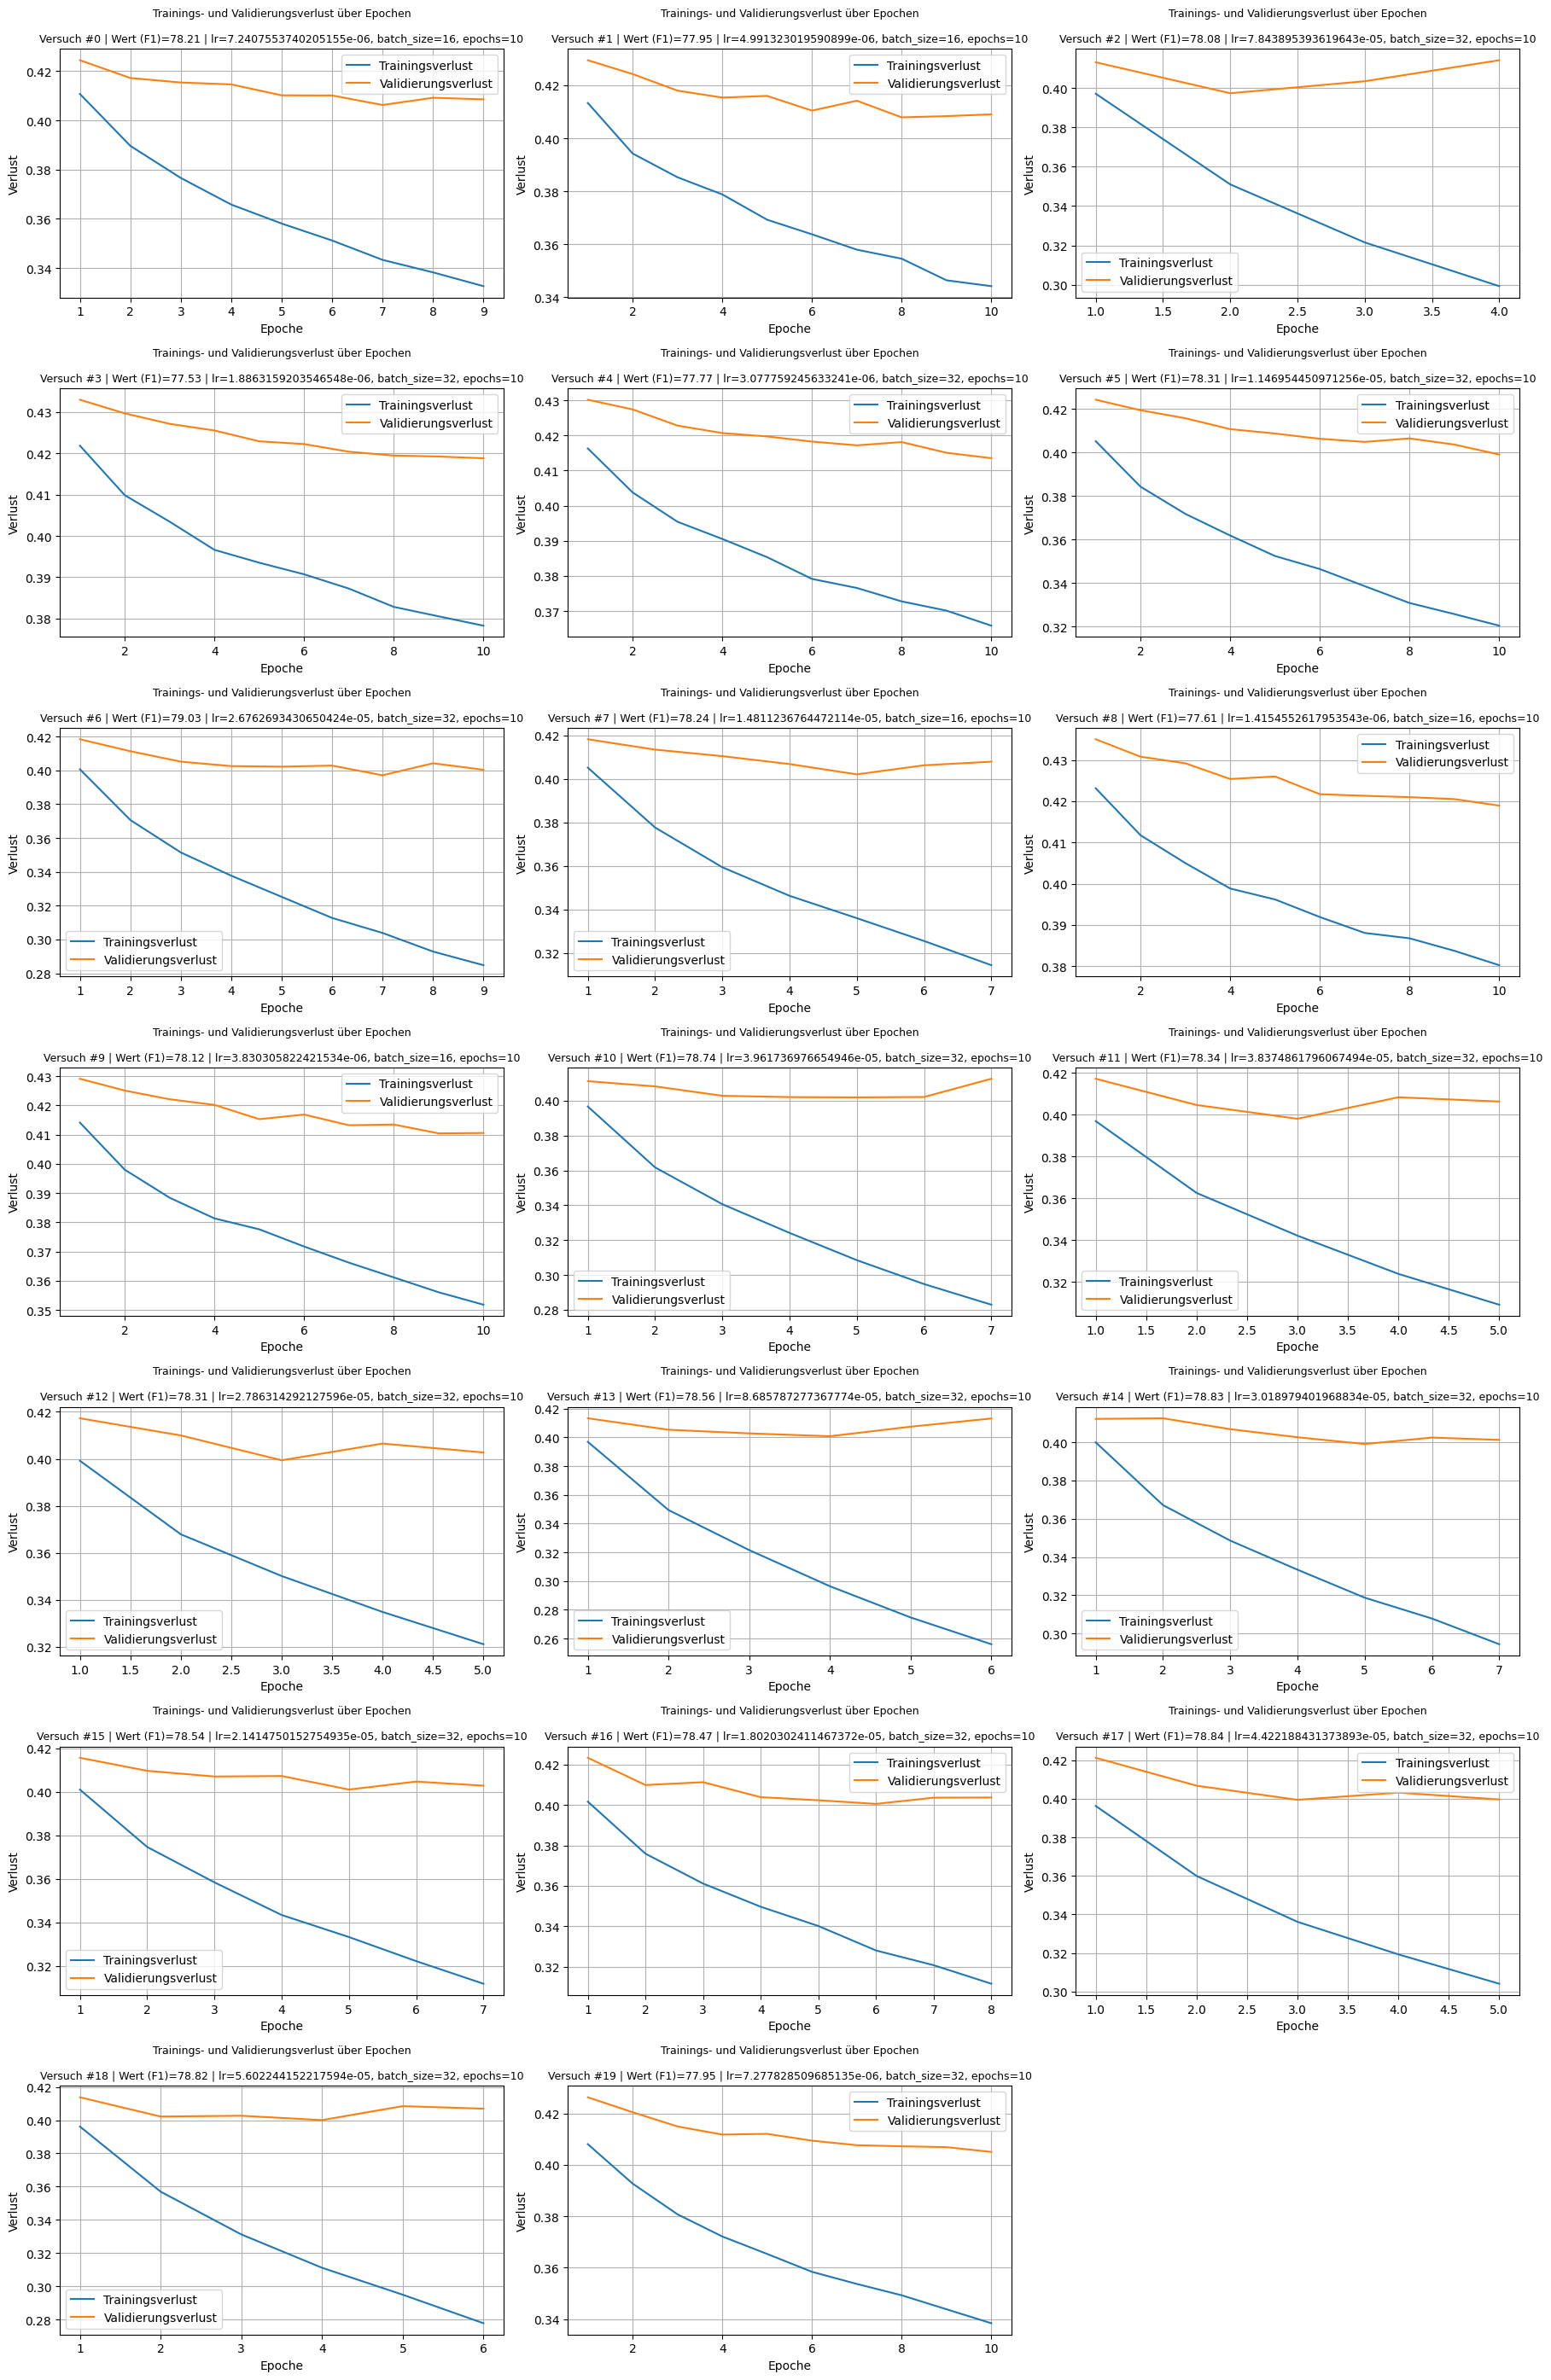

In [69]:
num_trials = len(T5_LOSS_TABLES) 

num_cols = 3
num_rows = math.ceil(num_trials / num_cols) 



fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6 * num_cols, 4 * num_rows))


axs_flat = axs.flatten() if num_trials > 1 else [axs]

for i, (df, trial) in enumerate(zip(T5_LOSS_TABLES, study_t5.trials)):
    ax = axs_flat[i]  

    trial_number = trial.number
    trial_value = trial.value
    trial_params = trial.params

    params_str = ", ".join([f"{k}={v}" for k, v in trial_params.items()])

    main_title = "Trainings- und Validierungsverlust über Epochen"
    subtitle = f"Versuch #{trial_number} | Wert (F1)={trial_value:.2f} | {params_str}"
    full_title = main_title + "\n\n" + subtitle

    # Plotten der Trainings- und Validierungsverlustkurven.
    ax.plot(df["Epoch"], df["Training Loss"], label="Trainingsverlust")
    ax.plot(df["Epoch"], df["Validation Loss"], label="Validierungsverlust")

    ax.set_xlabel("Epoche") 
    ax.set_ylabel("Verlust")
    ax.set_title(full_title, fontsize=9)
    ax.grid(True) 
    ax.legend()

if num_trials < len(axs_flat):
    for j in range(num_trials, len(axs_flat)):
        fig.delaxes(axs_flat[j])

plt.tight_layout() 
plt.show()  


### Analyse der Optuna-Trials für T5

Der Fokus lag auf der Maximierung des **F1-Scores**, und die Hyperparameter wurden wie folgt variiert:
- **Lernrate (`lr`)**: Zwischen 1 x 10 ** -6 und 1 x 10 **-4.
- **Batchgröße (`batch_size`)**: 16 oder 32.
- **Anzahl der Epochen (`epochs`)**: Festgelegt auf 10.

#### Zusammenfassung der Ergebnisse:
1. **Beste Leistung**:
   - Der höchste F1-Score beträgt **79.03**, erreicht in Versuch #6.
   - Die Hyperparameter für diesen Versuch:
     - **Lernrate:** 2.68 x 10 ** -5 
     - **Batchgröße:** 32
     - **Epochen:** 10
   - Diese Ergebnisse zeigen, dass mittlere Lernraten mit einer Batchgröße von 32 vorteilhaft sind.

2. **Durchschnittliche Leistung**:
   - Der durchschnittliche F1-Score über alle Versuche beträgt **78.03**.
   - Dies zeigt, dass das Training stabil ist und keine extrem niedrigen Ausreißer aufweist.

3. **Verteilung der F1-Scores**:
   - Die meisten Werte liegen im Bereich **77.5 - 79.0**.
   - Dies deutet darauf hin, dass die gewählten Hyperparameter-Suchräume sinnvoll gewählt wurden, da keine drastischen Leistungseinbrüche auftreten.

4. **Lernrate (`lr`)**:
   - Lernraten im Bereich von 1 x 10 ** -5 bis 5 x 10 ** -5 führten zu besseren F1-Scores (z. B. in Versuchen #6, #14, #17, #18).
   - Sehr niedrige Lernraten (1.42 x 10 ** -6  in Versuch #8) oder sehr hohe Lernraten (z. B. 8.69 x 10 ** -5 in Versuch #13) zeigten tendenziell schlechtere Ergebnisse.

5. **Batchgröße (`batch_size`)**:
   - Batchgröße 32 zeigte insgesamt bessere Ergebnisse als Batchgröße 16.
   - Von den 20 Versuchen erzielten 8 Versuche mit Batchgröße 32 einen F1-Score über 78.5, während dies bei Batchgröße 16 nur in wenigen Fällen erreicht wurde.




hier werde ich das T5-Modell für generative Frage-Antwort-Aufgaben (Question Answering) mithilfe der **besten Hyperparameter aus der Optuna-Studie** trainiert. Die Schritte umfassen:

1. **Initialisierung des T5-Modells und Trainers**:
   - Das **T5-Modell** wird in der Konfiguration `'t5-small'` geladen.
   - Ein **ModelTrainer**-Objekt wird erstellt, das den Tokenizer, die Datensätze und den Modelltyp konfiguriert.

2. **Training mit den besten Hyperparametern**:
   - Das Modell wird mit den aus **Versuch #6** der Optuna-Studie ermittelten Hyperparametern trainiert:
     - **Epochenanzahl (`epochs`)**.
     - **Batch-Größe (`batch_size`)**.
     - **Lernrate (`lr`)**.
   - Early Stopping wird verwendet, um das Training zu stoppen, wenn sich die Validierungsleistung nicht mehr verbessert.

3. **Speicherung des trainierten Modells**:
   - Das trainierte Modell wird unter dem Namen `t5.pt` gespeichert, um es für zukünftige Einsätze oder Tests zu laden.

#### Ziel:
Das T5-Modell wird speziell für die Aufgabe der Frage-Antwort-Generierung trainiert, mit optimierten Parametern, um maximale Leistung zu erzielen.



In [ ]:
# Laden des T5-Modells mit der Konfiguration 't5-small' aus den vortrainierten Modellen von Hugging Face.
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Initialisierung des ModelTrainer für das T5-Modell.
t5_trainer = ModelTrainer(
    model=t5_model,
    tokenizer=t5_tokenizer, 
    train_dataset=t5_train_dataset,
    val_dataset=t5_val_dataset, 
    model_type='t5' 
)

t5_trainer.train(
    epochs=study_t5.trials[6].params['epochs'],  
    batch_size=study_t5.trials[6].params['batch_size'], 
    early_stopping_patience=2,
    save_dir='./data',
    model_name='t5_qa',
    lr=study_t5.trials[6].params['lr'] 
)

# Speichern des trainierten T5-Modells in einer Datei.
t5_trainer.save_model('t5.pt')


c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2738/2738 [13:31<00:00,  3.37it/s, loss=0.497]


Epoch 1 - Training Loss: 0.3989, Validation Loss: 0.4175


Evaluating T5: 100%|██████████| 328/328 [01:45<00:00,  3.11it/s]


EM: 63.58, F1: 77.43


Epoch 2: 100%|██████████| 2738/2738 [13:29<00:00,  3.38it/s, loss=0.322]


Epoch 2 - Training Loss: 0.3674, Validation Loss: 0.4087


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.30it/s]


EM: 64.07, F1: 77.79


Epoch 3: 100%|██████████| 2738/2738 [13:28<00:00,  3.39it/s, loss=0.371]


Epoch 3 - Training Loss: 0.3516, Validation Loss: 0.4079


Evaluating T5: 100%|██████████| 328/328 [01:39<00:00,  3.31it/s]


EM: 64.30, F1: 78.04


Epoch 4: 100%|██████████| 2738/2738 [13:28<00:00,  3.39it/s, loss=0.482]


Epoch 4 - Training Loss: 0.3359, Validation Loss: 0.4006


Evaluating T5: 100%|██████████| 328/328 [01:36<00:00,  3.41it/s]


EM: 64.66, F1: 78.41


Epoch 5: 100%|██████████| 2738/2738 [13:28<00:00,  3.39it/s, loss=0.508] 


Epoch 5 - Training Loss: 0.3244, Validation Loss: 0.3992


Evaluating T5: 100%|██████████| 328/328 [01:36<00:00,  3.40it/s]


EM: 64.87, F1: 78.40


Epoch 6: 100%|██████████| 2738/2738 [13:28<00:00,  3.39it/s, loss=0.16] 


Epoch 6 - Training Loss: 0.3124, Validation Loss: 0.4018


Evaluating T5: 100%|██████████| 328/328 [01:38<00:00,  3.35it/s]


EM: 64.60, F1: 78.47


Epoch 7: 100%|██████████| 2738/2738 [13:28<00:00,  3.39it/s, loss=0.389]


Epoch 7 - Training Loss: 0.3023, Validation Loss: 0.4015


Evaluating T5: 100%|██████████| 328/328 [01:41<00:00,  3.24it/s]


EM: 64.79, F1: 78.56
Early stopping triggered


In [126]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Daten aus deiner Tabelle
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_loss = t5_trainer.get_loss_table()['Training Loss']
val_loss = t5_trainer.get_loss_table()['Validation Loss']
f1_score = t5_trainer.get_loss_table()['f1_score']
exact_match = t5_trainer.get_loss_table()['exact_match']

# Erstelle Subplots: 1 Reihe, 2 Spalten
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    subplot_titles=('Training und Validierung Verlust', 'F1-Score und Exact Match'),
    shared_xaxes=True,
    vertical_spacing=0.1,
    specs=[[{"secondary_y": True}, {"secondary_y": True}]] 
)

# Füge den Trainingsverlust hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Trainingsverlust', line=dict(color='blue')),
    row=1, col=1
)

# Füge den Validierungsverlust hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validierungsverlust', line=dict(color='red')),
    row=1, col=1
)

# Füge den F1-Score hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=f1_score, mode='lines+markers', name='F1-Score', line=dict(color='green')),
    row=1, col=2
)

# Füge den Exact Match (exakte Übereinstimmung) hinzu
fig.add_trace(
    go.Scatter(x=epochs, y=exact_match, mode='lines+markers', name='Exact Match', line=dict(color='orange')),
    row=1, col=2
)

# Layout anpassen mit Titeln und Achsenbezeichnern
fig.update_layout(
    title_text='Training/Validierungsverlust und Evaluationsmetriken',
    xaxis_title='Epoch',
    showlegend=True,
    height=500
)

# Y-Achse für den ersten Subplot (Verlust) anpassen
fig.update_yaxes(title_text='Verlust', row=1, col=1)

# Y-Achse für den zweiten Subplot (F1-Score und Exact Match) anpassen
fig.update_yaxes(title_text='Punktzahl', row=1, col=2)

# Das Diagramm anzeigen
fig.show()


# Erstellung eines Prompt-Datensatzes aus SQuAD-Daten

<a id='erstellung2'></a>


In dieser nachsten Zelle wird ein Datensatz erstellt, der für Modelle wie T5 verwendet werden kann, um generative Aufgaben zu trainieren oder zu bewerten. Der Schwerpunkt liegt auf der Erstellung eines kontextbezogenen Prompts und der Strukturierung der Daten für ein einfaches Training.

#### Hauptpunkte:
1. **Definition des Prompts**:
   - Ein Prompt wird definiert, um sicherzustellen, dass Antworten nur auf den gegebenen Kontext beschränkt sind.
   - Der Prompt verbietet jegliche zusätzliche Informationen oder Erläuterungen, die nicht im Kontext enthalten sind.

2. **Verarbeitung der Daten**:
   - Extrahiert **Kontext**, **Fragen** und **Antworten** aus der Tabelle.
   - Erstellt eine Spalte, die **Frage und Kontext** kombiniert.
   - Berechnet die **Startposition der Antwort** innerhalb des Kontexts.

3. **Strukturierung des Datensatzes**:
   - Erstellt einen neuen DataFrame mit den Spalten:
     - `context`: Der ursprüngliche Kontext.
     - `question`: Die Frage.
     - `answer`: Die exakte Antwort.
     - `start_position`: Die Startposition der Antwort im Kontext.
     - `full_context_and_question`: Kombinierter Kontext und Frage.
     - `original_context`: Der ursprüngliche Kontext.
     - `id`: Eine eindeutige ID für jeden Eintrag.

4. **Speicherung und Nutzung**:
   - Der Datensatz wird in eine Excel-Datei exportiert (`TD_B_prompt.xlsx`) und kann für weitere Analysen oder Trainingszwecke genutzt werden.
   - Extrahiert relevante Spalten wie IDs, Fragen und Antworten für spezifische Anwendungen.

#### Ziel:
Dieser Schritt organisiert und formatiert die Daten für ein Modelltraining und stellt sicher, dass die Antworten strikt auf den Kontext beschränkt bleiben.



In [107]:
def create_prompt_dataset(table, context=False):
    # Definition eines Prompts, der die Antwort strikt auf die im Kontext gegebene Information beschränkt.
    context_prompt = ''' 
    \n\nProvide only the exact answer to the questions from the SQuAD dataset, ensuring no additional context, elaboration, or supplementary details are included. 
    Your responses must strictly adhere to the relevant passages from the dataset, offering nothing beyond the precise text necessary to answer the question. 
    Under no circumstances should you incorporate external information or expand on details that are not present in the dataset.'''
    
    # Extrahieren der Kontexte und Anhängen des Prompts, falls erforderlich.
    contexts = table['context'].values.tolist()
    if not context:
        contexts = [context + context_prompt for context in contexts]

    # Extrahieren der Fragen und Antworten.
    questions = table['question'].values.tolist()
    answers = table['answers'].values.tolist()

    # Flachen der Antwortliste, um die erste Antwort aus jeder Liste zu erhalten.
    answers = [value['text'][0] for value in answers]

    # Bestimmen der Startpositionen der Antworten im Kontext.
    start_positions = [value['answer_start'][0] for value in table['answers'].values.tolist()]

    # Kombinieren von Kontext und Frage für eine vollständige Interaktionsvorlage.
    full_context_and_question = [context + "\n\n" + question for context, question in zip(contexts, questions)]

    # Erstellen eines neuen DataFrames mit den strukturierten Daten.
    table = pd.DataFrame({
        'context': contexts,
        'question': questions,
        'answer': answers,
        'start_position': start_positions,
        'full_context_and_question': full_context_and_question,
        'original_context': table['context'].values.tolist()
    })

    # Zuweisen von sequentiellen IDs zu jedem Eintrag.
    table['id'] = [i for i in range(len(table))]

    return table

# Annahme: TD_B ist ein DataFrame mit der benötigten Struktur.
table = create_prompt_dataset(TD_B)

# Optional: Speichern des Datensatzes in einer Excel-Datei.
# table.to_excel('TD_B_prompt.xlsx', index=False)

# Laden des gespeicherten Datensatzes für die weitere Verarbeitung.
table = pd.read_excel('TD_B_prompt.xlsx')

# Extrahieren spezifischer Felder für weitere Verarbeitung oder Analyse.
ids = table['id'].values.tolist()
full_question_context = table['full_context_and_question'].values.tolist()
questions = table['question'].values.tolist()
original_context = table['original_context'].values.tolist()
response = table['answer'].values.tolist()


# Generierung von Antworten mit DistilBERT und T5-Modellen

<a id='erstellung2'></a>


In dieser Zelle wird eine Funktion definiert, die Antworten auf gegebene Fragen auf der Basis eines Kontextes generiert. Die Funktion unterstützt sowohl das **DistilBERT**- als auch das **T5-Modell**. Danach wird die Funktion verwendet, um Antworten für eine Liste von Fragen zu generieren.

#### Hauptpunkte:
1. **Funktion `answer_question`**:
   - Unterstützt die beiden Modelltypen:
     - **DistilBERT**: Extrahiert die Antwort aus dem Kontext basierend auf den vorhergesagten Start- und Endpositionen.
     - **T5**: Generiert die Antwort als Textausgabe basierend auf der Eingabe von Frage und Kontext.
   - Die Funktion ist flexibel und kann auf CPU oder GPU ausgeführt werden.

2. **Antwortgenerierung**:
   - Antworten werden für jede Frage in einer Schleife generiert.
   - **`t5_response`**: Antworten des T5-Modells.
   - **`distilbert_response`**: Antworten des DistilBERT-Modells.

3. **Verwendung**:
   - Beide Modelle werden in den Evaluierungsmodus versetzt (`model.eval()`).
   - Die Ergebnisse der Generierung werden für jede Frage gespeichert.



In [108]:
def answer_question(model, tokenizer, context, question, model_type='distilbert', device='cuda', max_length=512):
    """
    Gibt eine textuelle Antwort auf eine gegebene Frage basierend auf dem bereitgestellten Kontext zurück, unter Verwendung eines bestimmten Modells und Tokenizers.

    Argumente:
        model: Das trainierte Modell (entweder DistilBERT oder T5).
        tokenizer: Der zugehörige Tokenizer.
        context (str): Der Text des Kontexts.
        question (str): Die zu beantwortende Frage.
        model_type (str): Typ des Modells ('distilbert' oder 't5').
        device (str): Das verwendete Gerät ('cpu' oder 'cuda').
        max_length (int): Maximale Länge für die Codierung.

    Rückgabe:
        str: Die vom Modell vorhergesagte textuelle Antwort.
    """
    model.eval() 
    model.to(device)  

    if model_type == 'distilbert':
        # Tokenisierung des Kontexts und der Frage für DistilBERT.
        inputs = tokenizer(context, question, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt').to(device)
        with torch.no_grad():  
            outputs = model(**inputs)
            start_logits, end_logits = outputs.start_logits, outputs.end_logits

        # Ermittlung der Start- und Endpositionen der Antwort.
        start_index = torch.argmax(start_logits, dim=1).item()
        end_index = torch.argmax(end_logits, dim=1).item()
        if end_index < start_index:
            end_index = start_index  # Anpassung, falls der Endindex vor dem Startindex liegt.

        # Dekodieren der Antwort aus den Tokens.
        answer_tokens = inputs["input_ids"][0][start_index:end_index + 1]
        answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
        return answer

    elif model_type == 't5':
        # Formatieren der Eingabe für T5 gemäß den Anforderungen.
        input_text = f"question: {question}  context: {context}"
        inputs = tokenizer(input_text, return_tensors='pt', max_length=max_length, truncation=True).to(device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=50, num_beams=1, early_stopping=True)
        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return answer

    else:
        raise ValueError("Unsupported model type. Choose 'distilbert' or 't5'.")

t5_response = []
distilbert_response = []

# Schleife zur Generierung von Antworten für jede Frage.
for index, id in enumerate(ids):
    # Antworten mit dem T5-Modell generieren.
    t5_response.append(answer_question(
        t5_trainer.get_model(), 
        t5_tokenizer, 
        original_context[index], 
        questions[index], 
        model_type='t5', 
        device='cuda'
    ))
    
    # Antworten mit dem DistilBERT-Modell generieren.
    distilbert_response.append(answer_question(
        distilbert_trainer.get_model(), 
        distilbert_tokenizer, 
        original_context[index], 
        questions[index], 
        model_type='distilbert', 
        device='cuda'
    ))


c:\Users\Sorel Tahata Djoumsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:638: UserWarning:

`num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.



# Inference mit Llama-2-7b und OpenAI GPT

<a id='inference'></a>




Ich definiere Funktionen definiert, um Antworten mit den Modellen **Llama-2-7b** und **OpenAI GPT** zu generieren. Diese Modelle werden verwendet, um Eingaben (z. B. Fragen im Kontext) zu verarbeiten und generative Antworten zu erzeugen.

#### Hauptpunkte:
1. **Definition der Inferenz-Funktionen**:
   - **`inference_llama_2_7_b`**:
     - Nutzt das **Llama-2-7b-Modell** von Hugging Face für Textgenerierung.
     - Verwendet die `pipeline`-API und ein Verbindungstoken, das aus der Umgebungsvariablen gelesen wird.
     - Löscht nach der Inferenz die CUDA-Zwischenspeicher und entfernt das Pipeline-Objekt, um Speicher freizugeben.
   - **`openai_inference`**:
     - Nutzt die **OpenAI GPT-API** (z. B. GPT-4) für Chat-Inferenzen.
     - Übermittelt Eingaben im Chat-Format und gibt die Antwort des Modells zurück.

2. **Laden von gespeicherten Antworten**:
   - **Antworten aus `answers.json`**:
     - Antworten von Llama und OpenAI werden aus einer JSON-Datei geladen, um Inferenzkosten zu vermeiden.

3. **(Optional) Inferenz ausführen**:
   - Kommentare zeigen, wie die Inferenz für beide Modelle auf einem Testdatensatz durchgeführt werden kann.
   - Antworten werden basierend auf den kombinierten Fragen und Kontexten (`full_question_context`) generiert.

#### Ziel:
Das Ziel ist es, Antworten sowohl mit Llama-2-7b als auch mit OpenAI GPT zu generieren und sie für spätere Analysen oder Vergleiche zu speichern.


In [109]:
def inference_llama_2_7_b(msg):
    """
    Generiert Antworten mit dem Llama-2-7b-Modell, das auf Hugging Face gehostet wird.
    
    Argumente:
        msg (str): Nachricht oder Eingabe, die an das Modell übergeben wird.
    
    Rückgabe:
        str: Generierter Textinhalt aus der Antwort.
    """
    # Verbindungstoken aus Umgebungsvariablen abrufen.
    token = os.getenv('HUGGING_FACE_CONNECTION_TOKEN')
    # Erstellen einer Textgenerierungs-Pipeline für Llama-2-7b.
    pipe = pipeline("text-generation", model="meta-llama/Llama-2-7b-chat-hf", token=token, device=0)
    # Generieren der Antwort.
    result = pipe([{"role": "user", "content": msg}])
    torch.cuda.empty_cache()  # CUDA-Zwischenspeicher löschen.
    del pipe  # Pipeline-Objekt entfernen, um Speicher freizugeben.
    return result[0]['generated_text'][1]['content']

def openai_inference(message):
    """
    Generiert Antworten mit dem OpenAI GPT-Modell.
    
    Argumente:
        message (str): Nachricht oder Eingabe, die an das Modell übergeben wird.
    
    Rückgabe:
        str: Antwort des Modells.
    """
    # OpenAI-Client initialisieren.
    client = OpenAI(api_key=os.getenv('API_KEY_OPENAI'))
    # Anfrage an das GPT-Modell senden.
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": message}
        ]
    )
    return completion.choices[0].message.content

# Antworten aus einer JSON-Datei laden.
with open('data/answers.json', 'r') as f:
    data2 = json.load(f)

# Listen mit gespeicherten Antworten.
open_ai_response = data2['chatgpt-4o-mini']
llama_response = data2['Llama_response']

# # Uncomment, um Inferenz für Llama und OpenAI auszuführen (kann kostenpflichtig sein).

# # Llama-Inferenz auf Testdatensätzen
# for index, id in enumerate(ids):
#     llama_response.append(inference_llama_2_7_b(full_question_context[index]))

# # ChatGPT-Inferenz auf Testdatensätzen
# for index, id in enumerate(ids):
#     llama_response.append(inference_llama_2_7_b(full_question_context[index]))
#     open_ai_response.append(openai_inference(full_question_context[index]))


# Erstellung eines DataFrames zur Konsolidierung der Modellantworten

<a id='erstellung3'></a>


In [112]:
# Sicherstellen, dass alle Antwortlisten dieselbe Länge haben, um Fehler zu vermeiden.
length = min(len(open_ai_response), len(llama_response), len(t5_response), len(distilbert_response), len(response))

# Erstellung eines DataFrames mit den Modellantworten und den korrekten Antworten.
df = pd.DataFrame(
    {
        'id': [i for i in range(length)],  
        'chatgpt-4o-mini': open_ai_response[:length],
        'Llama_2_7_b': llama_response[:length], 
        'T5': t5_response[:length],
        'Distilbert': distilbert_response[:length],
        'response': response[:length]
    }
)

# Verknüpfung des neuen DataFrames mit dem ursprünglichen Datensatz basierend auf der ID-Spalte.
df = pd.merge(table, df, on='id', how='inner')

df.to_excel('TD_B_prompt_responses.xlsx', index=False)

df.head()


,context,question,answer,start_position,full_context_and_question,original_context,id,chatgpt-4o-mini,Llama_2_7_b,T5,Distilbert,response
0,"In the first half of the 17th century, a plagu...",How many were killed by plague in Naples in 1656?,"about half of Naples' 300,000 inhabitants",150,"In the first half of the 17th century, a plagu...","In the first half of the 17th century, a plagu...",0,"About half of Naples' 300,000 inhabitants.","About half of Naples' 300,000 inhabitants.",half,"about half of naples ' 300, 000","about half of Naples' 300,000 inhabitants"
1,The United Methodist Church understands itself...,What book recognizes the importance of the Cha...,The Book of Discipline,243,The United Methodist Church understands itself...,The United Methodist Church understands itself...,1,The Book of Discipline,The Book of Discipline,The Book of Discipline,book of discipline,The Book of Discipline
2,"In the years after these rumors, neither Tesla...",Who received a bid in 1915?,Edison,51,"In the years after these rumors, neither Tesla...","In the years after these rumors, neither Tesla...",2,Edison,Edison,Edison,edison,Edison
3,"However, attempting to reconcile electromagnet...",What was used to create a new electromagnetic ...,quantum mechanics,283,"However, attempting to reconcile electromagnet...","However, attempting to reconcile electromagnet...",3,Quantum mechanics was used to create a new ele...,Quantum mechanics was used to create a new ele...,quantum mechanics,quantum,quantum mechanics
4,John Dalton's original atomic hypothesis assum...,What was Dalton's erroneous formula for water?,HO,243,John Dalton's original atomic hypothesis assum...,John Dalton's original atomic hypothesis assum...,4,HO,HO,HO,ho,HO


In [113]:
def evaluate_predictions(contexts, questions, references, predictions):
    """
    Bewertet eine Liste von Modellantworten anhand einer Liste von Referenzantworten.

    Argumente:
        contexts (list): Liste der Kontexte (wird nicht für EM/F1 verwendet, dient aber der Konsistenz).
        questions (list): Liste der Fragen.
        references (list): Liste der korrekten Referenzantworten.
        predictions (list): Liste der Modellantworten.

    Rückgabe:
        float, float: Durchschnittlicher EM-Score und F1-Score über alle Beispiele.
    """
    total_em = 0
    total_f1 = 0
    n = len(predictions)
    for pred, ref in zip(predictions, references):
        total_em += compute_exact_match(pred, ref) 
        total_f1 += compute_f1(pred, ref)  

    avg_em = 100.0 * total_em / n  
    avg_f1 = 100.0 * total_f1 / n  
    return avg_em, avg_f1

result = {}
for model in ['Llama_2_7_b', 'T5', 'Distilbert', 'chatgpt-4o-mini']:
    if model != 'id':  
        contexts = df['context'].values.tolist()  
        questions = df['question'].values.tolist()  
        references = df['response'].values.tolist()  
        predictions = df[model].values.tolist()  
        em, f1 = evaluate_predictions(contexts, questions, references, predictions)  # EM und F1 berechnen.
        result[model] = {'Exact Match Score': em, 'F1 Score': f1}  # Ergebnisse speichern.

# Ausgabe der Ergebnisse.
pd.DataFrame(result).T


,Exact Match Score,F1 Score
Llama_2_7_b,61.0,79.759531
T5,64.0,78.169473
Distilbert,51.0,66.654936
chatgpt-4o-mini,61.0,79.759531


### Analyse der Ergebnisse



### 1. **Exact Match Score (EM)**
- **T5 (64.0%)** erreicht den höchsten Exact Match Score. Dies deutet darauf hin, dass dieses Modell die Fähigkeit hat, exakte Antworten häufiger zu liefern als die anderen Modelle.
- **Llama_2_7_b (61.0%)** und **chatgpt-4o-mini (61.0%)** haben denselben EM-Wert, was darauf hinweist, dass beide Modelle ähnlich gut in der präzisen Beantwortung von Fragen sind.
- **Distilbert (51.0%)** liegt deutlich unter den anderen Modellen, was darauf hinweist, dass es Schwierigkeiten hat, exakte Antworten zu liefern.

---

### 2. **F1 Score**
- **Llama_2_7_b (79.76%)** und **chatgpt-4o-mini (79.76%)** haben die höchsten F1-Werte, was darauf hindeutet, dass sie gut darin sind, Antworten bereitzustellen, die teilweise korrekt oder relevant sind.
- **T5 (78.17%)** ist nah an Llama_2_7_b und chatgpt-4o-mini, was zeigt, dass es fast ebenso gut ist, wenn man ungenaue, aber relevante Antworten berücksichtigt.
- **Distilbert (66.65%)** liegt erneut weit hinter den anderen Modellen zurück und zeigt, dass es sowohl in Präzision als auch in Teilgenauigkeit Schwächen aufweist.

---

### 3. **Vergleich von EM und F1**
- **T5**: Hat den höchsten EM-Wert, aber nicht den höchsten F1-Wert. Das deutet darauf hin, dass es besser darin ist, exakte Antworten zu liefern, aber bei der Teilgenauigkeit geringfügig hinterherhinkt.
- **Llama_2_7_b und chatgpt-4o-mini**: Beide Modelle haben dieselben EM- und F1-Werte, was darauf schließen lässt, dass sie gut ausbalanciert sind und sowohl präzise als auch relevante Antworten liefern können.
- **Distilbert**: Hat sowohl beim EM als auch beim F1-Wert die niedrigsten Ergebnisse, was zeigt, dass es insgesamt weniger leistungsfähig ist.

---

### 4. **Einfluss von Modelltypen**
- **Llama_2_7_b und chatgpt-4o-mini**: Diese beiden Modelle scheinen am besten für generative und hybride Aufgaben geeignet zu sein, da sie sowohl hohe EM- als auch F1-Werte erzielen.
- **T5**: Eignet sich gut für präzise Aufgaben (hoher EM), könnte jedoch in Kontexten, in denen Teilinformationen relevant sind, leicht hinterherhinken.
- **Distilbert**: Seine geringere Leistung könnte auf eine einfachere Architektur oder eine begrenzte Fähigkeit zur Verarbeitung komplexer Kontexte hinweisen.



# Analyse der Leistung nach Fragetyp und Modell

<a id='analyse'></a>



Diese Zelle führt eine **Analyse der Leistung der Modelle** basierend auf unterschiedlichen **Fragetypen** durch. Fragen werden klassifiziert und die **Exact Match (EM)**- und **F1-Scores** für jede Modellantwort werden berechnet und visualisiert.

#### Hauptpunkte:
1. **Klassifizierung der Fragen**:
   - Fragen werden anhand ihrer ersten Wörter wie "What", "How", "When" etc. klassifiziert.
   - Die Klassifikation erfolgt in Kategorien wie **"Was", "Wie", "Wann"** und anderen.

2. **Gruppierung nach Fragetyp**:
   - Die Daten werden nach **Fragetyp** gruppiert, und für jede Gruppe werden die EM- und F1-Scores berechnet.

3. **Evaluation der Modelle**:
   - Für jedes Modell werden die Leistungsmesswerte (EM und F1) pro Fragetyp berechnet.
   - Die Ergebnisse werden in einem DataFrame gespeichert.



#### Ziel:
Die Analyse zeigt, wie gut die Modelle verschiedene Arten von Fragen beantworten können, und bietet Einblicke in spezifische Schwächen oder Stärken.



In [115]:
data = df.copy()

# Funktion zur Klassifizierung von Fragen basierend auf ihren Anfangswörtern.
def classify_question(question):
    if re.match(r'(?i)^what\b', question):  # Erkennung von "What"
        return 'Was'
    elif re.match(r'(?i)^how\b', question):  # Erkennung von "How"
        return 'Wie'
    elif re.match(r'(?i)^when\b', question):  # Erkennung von "When"
        return 'Wann'
    elif re.match(r'(?i)^where\b', question):  # Erkennung von "Where"
        return 'Wo'
    elif re.match(r'(?i)^who\b', question):  # Erkennung von "Who"
        return 'Wer'
    elif re.match(r'(?i)^which\b', question):  # Erkennung von "Which"
        return 'Welches'
    elif re.match(r'(?i)^why\b', question):  # Erkennung von "Why"
        return 'Warum'
    else:
        return 'Andere'  # Standardkategorie für nicht erkannte Fragen.

# Klassifizierung der Fragen in der Spalte 'question'.
data['Question_Type'] = data['question'].apply(classify_question)

# Definition der Modellspalten für die Auswertung.
model_columns = ['chatgpt-4o-mini', 'Llama_2_7_b', 'T5', 'Distilbert']

# Gruppieren der Daten nach Fragetyp.
grouped = data.groupby('Question_Type')

# Initialisierung eines Dictionaries zur Speicherung aller Ergebnisse.
all_model_results = []

# Auswertung der Modelle für jeden Fragetyp.
for model in model_columns:
    model_results = []
    for question_type, group in grouped:
        # Berechnung von EM und F1 für den aktuellen Fragetyp und das Modell.
        em, f1 = evaluate_predictions(group['context'], group['question'], group['answer'], group[model])
        model_results.append({
            'Model': model,
            'Question_Type': question_type,
            'Exact_Match': em,
            'F1_Score': f1
        })
    all_model_results.extend(model_results)

# Umwandlung der Ergebnisse in einen DataFrame.
final_results_df = pd.DataFrame(all_model_results)

# Speichern der Ergebnisse als Excel-Datei.
final_results_df_path = 'data/question_type_analysis_per_model.xlsx'
final_results_df.to_excel(final_results_df_path, index=False)

# Parameter für den Abstand zwischen Balkengruppen.
bargap_value = 0.6

# Erstellen eines gruppierten Balkendiagramms für Exact Match (EM).
em_fig = px.bar(
    final_results_df,
    x='Question_Type',
    y='Exact_Match',
    color='Model',
    barmode='group',
    title='Exact Match (EM) Analysis by Question Type and Model',
    labels={'Exact_Match': 'Exact Match Score (%)', 'Question_Type': 'Question Type'},
    height=600,
    width=1000
)

# Aktualisieren des Layouts für die Abstände.
em_fig.update_layout(bargap=bargap_value)
em_fig.show()


### Einfluss des Fragetypus auf die Modellergebnisse:

1. **Fragetypen mit klaren Fakten (z. B. "Wann", "Wer", "Wo"):**
   - Alle Modelle schneiden bei diesen Typen relativ ähnlich ab. Es scheint, dass diese Fragetypen weniger komplex sind und weniger Kontextverständnis erfordern.

2. **Fragetypen mit offenen oder erklärungsbasierten Antworten (z. B. "Warum", "Wie"):**
   - **T5** und **chatgpt-4o-mini** zeigen eine stärkere Leistung bei diesen Fragetypen.
   - **Distilbert** hat Schwierigkeiten mit diesen komplexeren Fragetypen, wahrscheinlich aufgrund von Architektur- und Modellgröße-Beschränkungen.

3. **Spezifische Herausforderungen bei "Was"- und "Welches"-Fragen:**
   - **T5** überragt bei diesen Fragetypen, was darauf hindeutet, dass es gut darin ist, präzise und umfangreiche Informationen zu verarbeiten.
   - **Distilbert** bleibt hier zurück, was darauf hinweist, dass es Schwierigkeiten mit Fragen hat, die spezifische oder detaillierte Antworten erfordern.



In [116]:
# Erstellen eines gruppierten Balkendiagramms für den F1-Score.
f1_fig = px.bar(
    final_results_df, 
    x='Question_Type',  
    y='F1_Score', 
    color='Model', 
    barmode='group', 
    title='F1-Score-Analyse nach Fragetyp und Modell', 
    labels={'F1_Score': 'F1-Score (%)', 'Question_Type': 'Fragetyp'},  
    height=600, 
    width=1000 
)

# Aktualisieren des Layouts, um den Abstand zwischen den Balkengruppen anzupassen.
f1_fig.update_layout(bargap=bargap_value)
f1_fig.show()


### Einfluss des Fragetypus auf die Modellergebnisse:

1. **Fragetypen mit klaren Antworten (z. B. "Wann", "Wer", "Wo"):**
   - Alle Modelle schneiden hier gut ab, da diese Fragetypen tendenziell weniger Kontextverständnis erfordern.

2. **Erklärungsbasierte Fragen (z. B. "Warum", "Wie"):**
   - **Distilbert** hat hier deutliche Schwächen.
   - **chatgpt-4o-mini** und **Llama_2_7_b** zeigen konsistent bessere Leistungen.
   - **T5** bleibt konkurrenzfähig, aber mit leichten Schwächen bei "Warum"-Fragen.

3. **Spezifische Fragen (z. B. "Was", "Welches"):**
   - **T5** zeigt bei "Was"-Fragen eine überlegene Leistung.
   - **Distilbert** hat Schwierigkeiten, präzise und umfassende Antworten zu liefern.



In [117]:
# Kopie des Ergebnistabellen-DataFrames für die Analyse.
analysis_data = final_results_df.copy()

# Berechnung der durchschnittlichen Leistung jedes Modells über alle Fragetypen.
model_performance = analysis_data.groupby('Model')[['Exact_Match', 'F1_Score']].mean()

# Berechnung der Leistung nach Fragetyp über alle Modelle.
question_type_performance = analysis_data.groupby('Question_Type')[['Exact_Match', 'F1_Score']].mean()

# Identifikation des besten Modells für jeden Fragetyp (basierend auf dem höchsten F1-Score).
best_model_per_type = analysis_data.loc[analysis_data.groupby('Question_Type')['F1_Score'].idxmax()]

# Anzeige der Tabellen mit den Ergebnissen.
for table in (model_performance, question_type_performance, best_model_per_type):
    display(table)  # Zeigt die Tabelle im Notebook an.
    print('\n\n')  # Fügt Leerzeilen zwischen den Tabellen ein.


,Exact_Match,F1_Score
Model,,
Distilbert,51.410256,67.821435
Llama_2_7_b,52.708333,74.554557
T5,49.775641,70.983403
chatgpt-4o-mini,52.708333,74.554557


,Exact_Match,F1_Score
Question_Type,,
Andere,66.250000,80.542576
Wann,70.000000,85.555556
Warum,12.500000,42.500000
Was,55.128205,73.305098
Welches,43.750000,69.583333
Wer,80.000000,86.893939
Wie,48.076923,69.947403
Wo,37.500000,67.500000


,Model,Question_Type,Exact_Match,F1_Score
0,chatgpt-4o-mini,Andere,75.000000,85.954248
17,T5,Wann,80.000000,88.888889
26,Distilbert,Warum,50.000000,50.000000
19,T5,Was,66.666667,78.474227
4,chatgpt-4o-mini,Welches,50.000000,76.666667
5,chatgpt-4o-mini,Wer,86.666667,94.393939
6,chatgpt-4o-mini,Wie,46.153846,75.420306
31,Distilbert,Wo,50.000000,83.333333


### Zusammenfassung und Analyse:

#### 1. **Leistung nach Modellen (Gesamtdurchschnitt):**
   - **Distilbert**:
     - **EM**: 51.41
     - **F1**: 67.82
     - Dieses Modell hat im Vergleich die niedrigste Leistung in beiden Metriken. Es zeigt, dass es Schwierigkeiten mit komplexen Kontexten hat.
   - **Llama_2_7_b** und **chatgpt-4o-mini**:
     - **EM**: 52.70
     - **F1**: 74.55
     - Beide Modelle liefern identische Ergebnisse, was darauf hindeutet, dass sie gut auf ähnliche Aufgaben optimiert sind.
   - **T5**:
     - **EM**: 49.78
     - **F1**: 70.98
     - T5 schneidet bei der F1-Metrik besser als Distilbert, bleibt jedoch hinter den anderen Modellen zurück.

#### 2. **Leistung nach Fragetypen (Gesamtdurchschnitt):**
   - **"Wer" (EM: 80.00, F1: 86.89)**:
     - Fragetyp mit den höchsten Durchschnittswerten. Die Modelle haben bei diesen präzisen Fragen eine starke Leistung.
   - **"Wann" (EM: 70.00, F1: 85.56)**:
     - Auch ein sehr gut performender Fragetyp, da die Antworten klar und präzise sind.
   - **"Warum" (EM: 12.50, F1: 42.50)**:
     - Schwächster Fragetyp in beiden Metriken. Dies zeigt, dass erklärungsbasierte Fragen für alle Modelle eine Herausforderung darstellen.
   - **"Wo" (EM: 37.50, F1: 67.50)**:
     - Zweitniedrigster Fragetyp, da "Wo"-Fragen oft detailliertere Kontextinformationen erfordern.
   - **"Was", "Wie", "Welches"**:
     - Mittelmäßige Leistung. Diese Fragetypen scheinen eine Mischung aus Präzision und Kontextverständnis zu erfordern, was Modelle unterschiedlich gut bewältigen.

#### 3. **Hervorhebung einzelner Modelle und Fragetypen:**
   - **chatgpt-4o-mini bei "Wer"-Fragen**:
     - EM: 86.67, F1: 94.39
     - Beste Leistung über alle Fragetypen und Modelle hinweg.
   - **T5 bei "Wann"-Fragen**:
     - EM: 80.00, F1: 88.89
     - T5 zeigt eine hervorragende Leistung bei "Wann"-Fragen, was auf gutes zeitliches Kontextverständnis hindeutet.
   - **Distilbert bei "Warum"-Fragen**:
     - EM: 50.00, F1: 50.00
     - Trotz der allgemeinen Schwächen bei "Warum"-Fragen zeigt Distilbert hier eine vergleichsweise bessere Leistung.

---

### Einfluss der Fragetypen auf die Modellergebnisse:
1. **Faktische Fragen (z. B. "Wann", "Wer"):**
   - Alle Modelle erzielen hier hohe Ergebnisse, da die Antworten oft präzise und eindeutig sind.
   - **chatgpt-4o-mini** und **Llama_2_7_b** zeigen dabei konsistente Leistungen.
   
2. **Erklärungsbasierte Fragen (z. B. "Warum", "Wie"):**
   - Die Leistung aller Modelle sinkt deutlich.
   - Dies zeigt, dass diese Fragetypen tiefere kontextuelle und erklärende Fähigkeiten erfordern.

3. **Spezifische Fragen (z. B. "Was", "Welches"):**
   - Mittlere Leistung, da sie sowohl präzise als auch kontextabhängige Antworten erfordern.
   - **T5** schneidet hier gut ab.

---

### Fazit:
- **Beste Modelle insgesamt**:
  - **chatgpt-4o-mini** und **Llama_2_7_b** zeigen konsistente und starke Leistungen über die meisten Fragetypen hinweg.
- **Einfluss der Fragetypen**:
  - Faktische Fragen ("Wann", "Wer") haben die höchsten Ergebnisse.
  - Erklärungsbasierte Fragen ("Warum", "Wie") sind für alle Modelle herausfordernd.

